To analyze Emergency Room (ER) treatment patterns, their co-prescription behavior, patient clustering, and association with mortality outcomes, using real-world, messy clinical text data.


* Co-Occurrence Analysis (Drug Combination Discovery)
* Chief Complaint NLP (Contextual Validation)


In [ ]:
!pip install pyvis

In [ ]:

# ==========================
# Data Manipulation & Handling
# ==========================
import pandas as pd         # DataFrames, CSV/Excel I/O, data cleaning
import re                   # Regular expressions for text cleaning
from collections import Counter  # Count occurrences of items in lists/columns
from itertools import combinations  # Generate pairwise or n-wise combinations

# ==========================
# Machine Learning & NLP
# ==========================
from sklearn.preprocessing import MultiLabelBinarizer  # Convert multi-label columns to binary format
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer  # Text vectorization
from sklearn.decomposition import LatentDirichletAllocation, PCA  # Topic modeling and dimensionality reduction
from sklearn.cluster import KMeans  # Clustering

# ==========================
# Statistical Analysis
# ==========================
from scipy.stats import fisher_exact  # Fisher's exact test for categorical data

# ==========================
# Visualization
# ==========================
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter  # Format axis labels
import seaborn as sns  # Advanced statistical visualizations
from wordcloud import WordCloud  # Word clouds for text data

# ==========================
# Network Analysis
# ==========================
import networkx as nx  # Graph/network analysis
from pyvis.network import Network  # Interactive network visualizations


In [ ]:
df = pd.read_csv("/content/TestData Set - Test Data.csv")
df.head()

Age (in years)  Gender  Respiratory Rate (per minute)  Is Intubated  \
0          32.00     1.0                           20.0           2.0   
1          76.00     1.0                           24.0           2.0   
2          58.00     1.0                           22.0           2.0   
3          72.00     1.0                           18.0           2.0   
4          24.00     2.0                           22.0           2.0   

   Systole BP (mmgh)  Dystole BP (mmgh) Measurement Method (BP)  Pulse (bpm)  \
0                100                 60            Auscultatory         88.0   
1                110                 70            Auscultatory         80.0   
2                100                 60            Auscultatory         86.0   
3                110                 70            Auscultatory         74.0   
4                120                 90            Auscultatory        114.0   

   Temperature (F)  Saturations  ...  \
0             99.6         95.0  ...   
1             98.0         80.0  ...   
2             98.6         98.0  ...   
3             97.0         97.0  ...   
4             97.0         98.0  ...   

                         Provisional Diagnosis at ER  \
0                                                NaN   
1                                                NaN   
2                              Chronic Liver Disease   
3  Alcohol Dependence Syndrome With Uncomplicated...   
4                                       Op Poisoning   

                     Final Discharge/death diagnosis  \
0                                                NaN   
1                                                NaN   
2  Decompensated Cld Secondary To Alcohol With He...   
3  Hospital Acquired Pneumonia With Alcohol Depen...   
4                              Op Poisoning With Uti   

                                   Comorbidities  \
0  Substance Abuse Tramadol Tablets And Cannabis   
1                       Obstructive Lung Disease   
2                                            NaN   
3                                            NaN   
4                                            NaN   

                          Use of any past medication  \
0  Paracetamol, Pantoprazole, Ceftriaxone, Vancom...   
1         Lasilactone, Formeterol Tiotropium Inhaler   
2                                                NaN   
3                                                NaN   
4                                                NaN   

                              Resuscitation Received  \
0  Fluid, Use of Vasopressors, Use of Invasive Ve...   
1                                              Fluid   
2                         Fluid, Use of Vasopressors   
3                                              Fluid   
4                                              Fluid   

      Resuscitation Received 1  Resuscitation Received 2  \
0                        Fluid                       NaN   
1                          NaN                       NaN   
2  Use of Invasive Ventilation                       NaN   
3                        Fluid       Use of Vasopressors   
4                        Fluid                       NaN   

      Resuscitation Received 3  Resuscitation Received 4  Mortality  
0                          NaN                       NaN      Alive  
1                          NaN                       NaN      Alive  
2                          NaN                       NaN      Alive  
3  Use of Invasive Ventilation                       CPR      Alive  
4                          NaN                       NaN      Alive  

[5 rows x 56 columns]

In [ ]:
df["treatment_raw"] = df["Treatment Received at ER"].fillna("").astype(str)
df["treatment_raw"]

0                                                       
1                                                       
2                                             Furosemide
3                                               Diazepam
4      Ondeetron,Pantoprazole,Atropine,Ampules,Atropi...
                             ...                        
592                                                     
593                                                     
594                                                     
595                                                     
596                                                     
Name: treatment_raw, Length: 597, dtype: object

In [ ]:
def clean_med_text(text):
    text = text.lower()

    # remove unwanted characters
    text = re.sub(r"[^a-z,]", "", text)

    # normalize common spelling variations
    replacements = {
        "ceftraxone": "ceftriaxone",
    "ceftriazone": "ceftriaxone",
    "cefotaxime": "cefotaxime",
    "flucloxacillin": "flucloxacillin",
    "amoxyclav": "amoxicillin_clavulanate",
    "vancomycin": "vancomycin",
    "levofloxacin": "levofloxacin",
    "clindamycin": "clindamycin",
    "penicillin": "penicillin",
    "cloxacillin": "cloxacillin",
    "gentamycin": "gentamicin",
    "metronidazole": "metronidazole",
    "ciprofloxacin": "ciprofloxacin",
    "roxithromycin": "roxithromycin",
    "doxycycline": "doxycycline",
    "azithromycin": "azithromycin",

    # GI / Anti-ulcer
    "pantaprazole": "pantoprazole",
    "pantop": "pantoprazole",
    "ondetron": "ondansetron",
    "ondeetron": "ondansetron",
    "ondeon": "ondansetron",
    "ranitidine": "ranitidine",
    "omeprazole": "omeprazole",
    "octreotide": "octreotide",
    "domperidome": "domperidone",
    "metoclopromide": "metoclopramide",

    # Analgesics / Antipyretics / NSAIDs
    "pcm": "paracetamol",
    "paracetamold": "paracetamol",
    "tramadol": "tramadol",
    "ketorolac": "ketorolac",
    "morphine": "morphine",
    "pethidine": "pethidine",
    "diclofenac": "diclofenac",

    # Diuretics / Fluids / Electrolytes
    "frusemide": "furosemide",
    "lasix": "furosemide",
    "rll": "ringer_lactate",
    "rl": "ringer_lactate",
    "ringer_lactate": "ringer_lactate",
    "dextrose": "dextrose",
    "ivfluid": "iv_fluids",
    "ivfluids": "iv_fluids",
    "ns": "iv_fluids",
    "normal": "iv_fluids",
    "saline": "iv_fluids",
    "meq": "",
    "done": "",
    "injectiondns": "",
    "ampules": "",

    # Cardiovascular / Vasopressors
    "adrenaline": "epinephrine",
    "noradrenaline": "norepinephrine",
    "labetolol": "labetalol",
    "metoprolol": "metoprolol",
    "verapamil": "verapamil",
    "adenosine": "adenosine",
    "aspirin": "aspirin",
    "clopidogrel": "clopidogrel",
    "atorvastatin": "atorvastatin",
    "glyceryl_trinitrate": "glyceryl_trinitrate",

    # Sedatives / Muscle relaxants / Anticonvulsants
    "diazepam": "diazepam",
    "lorazepam": "lorazepam",
    "midazolam": "midazolam",
    "ketamine": "ketamine",
    "succinylcholine": "succinylcholine",
    "vecuronium": "vecuronium",
    "levetiracetam": "levetiracetam",

    # Corticosteroids / Hormones
    "hydrocort": "hydrocortisone",
    "hydrocortisone": "hydrocortisone",
    "prednisolone": "prednisolone",
    "thiamine": "thiamine",
    "vitamin_k": "vitamin_k",
    "K": "vitamin_k",
    "D": "vitamin_D",
    "D": "vitamin_D",

    "insulin": "insulin",

    # Other / Miscellaneous
    "atropine": "atropine",
    "pralidoxime": "pralidoxime",
    "terbutaline": "terbutaline",
    "salbutamol": "salbutamol",
    "iulin": "insulin",
    "optineuron": "optineuron",
    "activated_charcoal": "activated_charcoal",
    "oxygen": "oxygen",
    "silver_sulfadiazine": "silver_sulfadiazine",
    "buscopan": "buscopan",
    "foleys": "foley_catheter",
    "nebulationlisation": "nebulization",
    "nebulation": "nebulization",
    "none": ""
    }

    for k, v in replacements.items():
        text = text.replace(k, v)

    return text

df["treatment_clean"] = df["treatment_raw"].apply(clean_med_text)
df["treatment_clean"]

0                                                       
1                                                       
2                                             furosemide
3                                               diazepam
4      ondaiv_fluidsetron,pantoprazolerazole,atropine...
                             ...                        
592                                                     
593                                                     
594                                                     
595                                                     
596                                                     
Name: treatment_clean, Length: 597, dtype: object

In [ ]:

# Function to Clean & Standardize Medication Names
# Convert Cleaned Text into List of Treatments

df["treatment_list"] = df["treatment_clean"].apply(
    lambda x: [i.strip() for i in x.split(",") if i.strip()]
)


df["treatment_list"]

0                                                     []
1                                                     []
2                                           [furosemide]
3                                             [diazepam]
4      [ondaiv_fluidsetron, pantoprazolerazole, atrop...
                             ...                        
592                                                   []
593                                                   []
594                                                   []
595                                                   []
596                                                   []
Name: treatment_list, Length: 597, dtype: object

In [ ]:
# Map textual mortality outcomes to numeric classes for modeling/analysis



outcome_mapping = {
    "Alive": 0,
    "Left Against Medical Advice": 1,
    "Within 7 Days Mortality": 2,
    "In-Hospital Mortality (>7 Days)": 3,
    "Ed Mortality": 4
}

# Apply Mapping to DataFrame

df["outcome_class"] = df["Mortality"].map(outcome_mapping)
df["outcome_class"]

0      0
1      0
2      0
3      0
4      0
      ..
592    0
593    0
594    0
595    0
596    0
Name: outcome_class, Length: 597, dtype: int64

In [ ]:
# One-Hot Encode Treatments
# Create a DataFrame of medications (columns = medication names)
# Convert the list of treatments into binary features for analysis

mlb = MultiLabelBinarizer()
X_meds = mlb.fit_transform(df["treatment_list"])

med_df = pd.DataFrame(
    X_meds,
    columns=mlb.classes_
)

med_df["outcome"] = df["outcome_class"].values

# Compute Average Medication Use by Outcome
# For each outcome class, calculate the mean usage of each treatment

med_means = med_df.groupby("outcome").mean()


In [ ]:
# Convert numeric outcome codes back to readable labels & Display Top Medications by Outcome

reverse_map = {v: k for k, v in outcome_mapping.items()}

for outcome_id in med_means.index:
    print(f"\nTop medications for {reverse_map[outcome_id]}")
    print(
        med_means
        .loc[outcome_id]
        .sort_values(ascending=False)
        .head(10)
    )



Top medications for Alive
injectionceftriaxone            0.216667
injectionpantoprazolerazole     0.191667
injectioniv_fluids              0.150000
iv_fluids                       0.141667
injectionparacetamol            0.108333
injectionhydrocortisoneisone    0.091667
nebulizationlization            0.083333
furosemide                      0.075000
pantoprazolerazole              0.066667
injectiondextrose               0.058333
Name: 0, dtype: float64

Top medications for Left Against Medical Advice
injectionceftriaxone            0.34
nebulizationlization            0.24
ceftriaxone                     0.20
injectiondextrose               0.16
injectionpantoprazolerazole     0.14
pantoprazolerazole              0.14
injectionhydrocortisoneisone    0.14
injectionfurosemide             0.12
injectiondopamine               0.10
injectionranitidine             0.08
Name: 1, dtype: float64

Top medications for Within 7 Days Mortality
injectionceftriaxone            0.371212
nebulizati

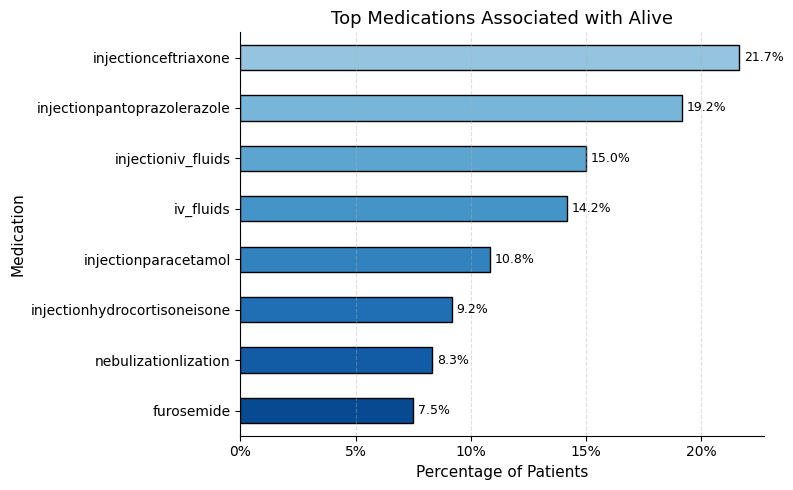

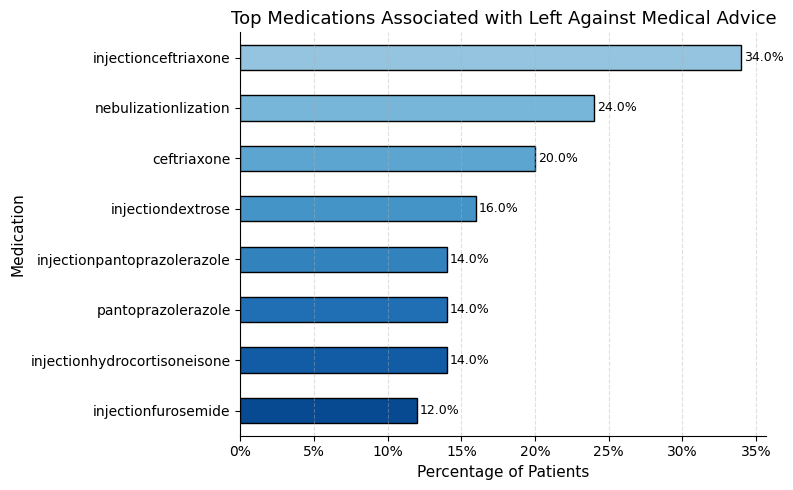

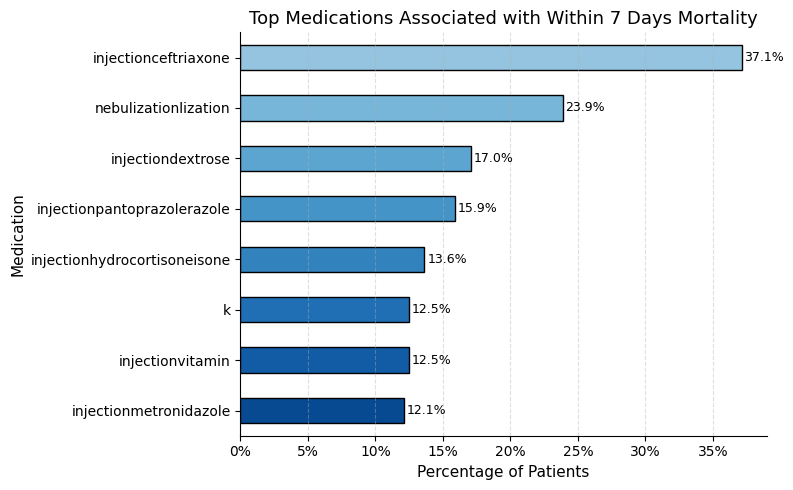

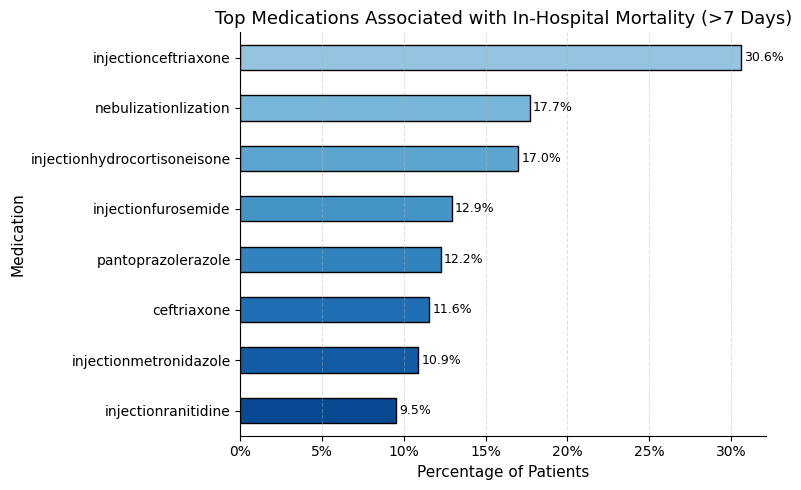

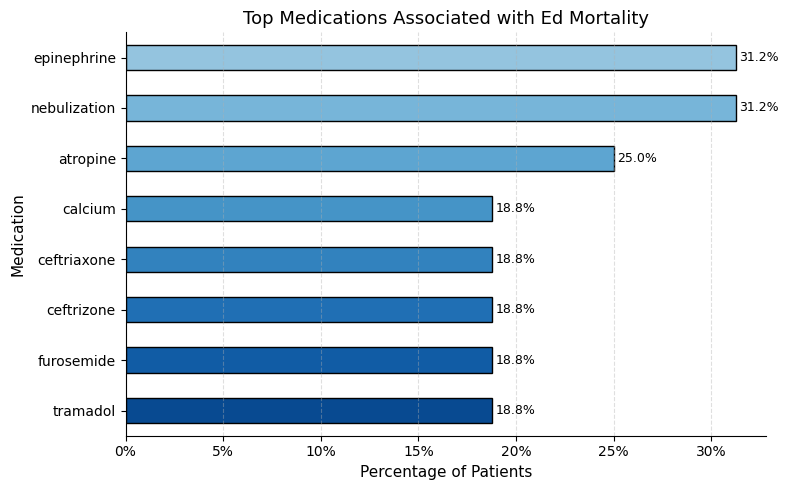

In [ ]:
# grpahing

for outcome_id in med_means.index:
    top_meds = (
        med_means
        .loc[outcome_id]
        .sort_values(ascending=False)
        .head(8)
    )

    fig, ax = plt.subplots(figsize=(8,5))

    # Gradient color based on value
    colors = plt.cm.Blues(np.linspace(0.4, 0.9, len(top_meds)))

    top_meds.plot(
        kind="barh",
        ax=ax,
        color=colors,
        edgecolor="black"
    )

    # Formatting
    ax.invert_yaxis()
    ax.set_title(f"Top Medications Associated with {reverse_map[outcome_id]}", fontsize=13)
    ax.set_xlabel("Percentage of Patients", fontsize=11)
    ax.set_ylabel("Medication", fontsize=11)

    # Convert x-axis to percentage
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x*100:.0f}%"))

    # Add percentage labels
    for i, v in enumerate(top_meds):
        ax.text(
            v + 0.002,
            i,
            f"{v*100:.1f}%",
            va="center",
            fontsize=9
        )

    # Clean look
    ax.spines[['top', 'right']].set_visible(False)
    ax.grid(axis='x', linestyle='--', alpha=0.4)

    plt.tight_layout()
    plt.show()


In [ ]:
# for outcome_id in med_means.index:
#     top_meds = (
#         med_means
#         .loc[outcome_id]
#         .sort_values(ascending=False)
#         .head(8)
#     )

#     plt.figure()
#     top_meds.plot(kind="barh")
#     plt.title(f"Medications Associated with {reverse_map[outcome_id]}")
#     plt.xlabel("Proportion of Patients")
#     plt.ylabel("Medication")
#     plt.show()


In [ ]:
# -------------------------------
# Step 1: Clean / Tokenize Medications (NLP-like)
# -------------------------------
# Simple abbreviation dictionary
abbrev_dict = {
    "pcm": "paracetamol",
    "paracetamol": "paracetamol",
    "vitamin d": "vitamin_d",
    "d": "vitamin_d",
    "tramadol": "tramadol",
    "pantop": "pantoprazole",
    "pantoprazole": "pantoprazole",
    "iv fluids": "iv_fluids",
    "rl": "ringer_lactate",
    "rll": "ringer_lactate",
    "furosemide": "furosemide",
    "vancomycin": "vancomycin",
    "ciprofloxacin": "ciprofloxacin",
    "metronidazole": "metronidazole",
    "ranitidine": "ranitidine",
        # Antibiotics / Antimicrobials
    "ceftraxone": "ceftriaxone",
    "ceftriazone": "ceftriaxone",
    "cefotaxime": "cefotaxime",
    "flucloxacillin": "flucloxacillin",
    "amoxyclav": "amoxicillin_clavulanate",
    "vancomycin": "vancomycin",
    "levofloxacin": "levofloxacin",
    "clindamycin": "clindamycin",
    "penicillin": "penicillin",
    "cloxacillin": "cloxacillin",
    "gentamycin": "gentamicin",
    "metronidazole": "metronidazole",
    "ciprofloxacin": "ciprofloxacin",
    "roxithromycin": "roxithromycin",
    "doxycycline": "doxycycline",
    "azithromycin": "azithromycin",

    # GI / Anti-ulcer
    "pantaprazole": "pantoprazole",
    "pantop": "pantoprazole",
    "ondetron": "ondansetron",
    "ondeetron": "ondansetron",
    "ondeon": "ondansetron",
    "ranitidine": "ranitidine",
    "omeprazole": "omeprazole",
    "octreotide": "octreotide",
    "domperidome": "domperidone",
    "metoclopromide": "metoclopramide",

    # Analgesics / Antipyretics / NSAIDs
    "pcm": "paracetamol",
    "paracetamold": "paracetamol",
    "tramadol": "tramadol",
    "ketorolac": "ketorolac",
    "morphine": "morphine",
    "pethidine": "pethidine",
    "diclofenac": "diclofenac",

    # Diuretics / Fluids / Electrolytes
    "frusemide": "furosemide",
    "lasix": "furosemide",
    "rll": "ringer_lactate",
    "rl": "ringer_lactate",
    "ringer_lactate": "ringer_lactate",
    "dextrose": "dextrose",
    "ivfluid": "iv_fluids",
    "ivfluids": "iv_fluids",
    "ns": "iv_fluids",
    "normal": "iv_fluids",
    "saline": "iv_fluids",

    # Cardiovascular / Vasopressors
    "adrenaline": "epinephrine",
    "noradrenaline": "norepinephrine",
    "labetolol": "labetalol",
    "metoprolol": "metoprolol",
    "verapamil": "verapamil",
    "adenosine": "adenosine",
    "aspirin": "aspirin",
    "clopidogrel": "clopidogrel",
    "atorvastatin": "atorvastatin",
    "glyceryl_trinitrate": "glyceryl_trinitrate",

    # Sedatives / Muscle relaxants / Anticonvulsants
    "diazepam": "diazepam",
    "lorazepam": "lorazepam",
    "midazolam": "midazolam",
    "ketamine": "ketamine",
    "succinylcholine": "succinylcholine",
    "vecuronium": "vecuronium",
    "levetiracetam": "levetiracetam",

    # Corticosteroids / Hormones
    "hydrocort": "hydrocortisone",
    "hydrocortisone": "hydrocortisone",
    "prednisolone": "prednisolone",
    "thiamine": "thiamine",
    "vitamin_k": "vitamin_k",
    "insulin": "insulin",

    # Other / Miscellaneous
    "atropine": "atropine",
    "pralidoxime": "pralidoxime",
    "terbutaline": "terbutaline",
    "salbutamol": "salbutamol",
    "activated_charcoal": "activated_charcoal",
    "oxygen": "oxygen",
    "silver_sulfadiazine": "silver_sulfadiazine",
    "buscopan": "buscopan",
    "foleys": "foley_catheter",
    "nebulationlisation": "nebulization",
    "nebulation": "nebulization",
    "none": ""
}

    # add more common meds as needed



In [ ]:
#  Define NLP-Based Medication Cleaning Function

'''
Steps:
    1. Lowercase the text.
    2. Replace punctuation with commas.
    3. Split text into tokens by commas, semicolons, or whitespace.
    4. Map abbreviations to standardized medication names.
    5. Remove duplicates.

'''

def nlp_clean_med(text):
    if not isinstance(text, str):
        return []
    text = text.lower()
    # replace punctuation with comma
    text = re.sub(r"[^a-z0-9\s]", ",", text)
    # split by comma or space
    tokens = re.split(r"[,;\s]+", text)
    # map abbreviations to standard names
    meds = [abbrev_dict.get(tok.strip(), tok.strip()) for tok in tokens if tok.strip()]
    # remove duplicates
    return list(set(meds))

df['treatment_list_nlp'] = df['treatment_raw'].apply(nlp_clean_med)


Top 10 Co-prescribed Medication Pairs:
ceftriaxone + pantoprazole: 32 patients
ceftriaxone + hydrocortisone: 17 patients
furosemide + hydrocortisone: 16 patients
hydrocortisone + pantoprazole: 16 patients
iv_fluids + iv_fluids: 16 patients
pantoprazole + paracetamol: 15 patients
furosemide + pantoprazole: 14 patients
ceftriaxone + paracetamol: 13 patients
ceftriaxone + furosemide: 13 patients
atropine + epinephrine: 11 patients


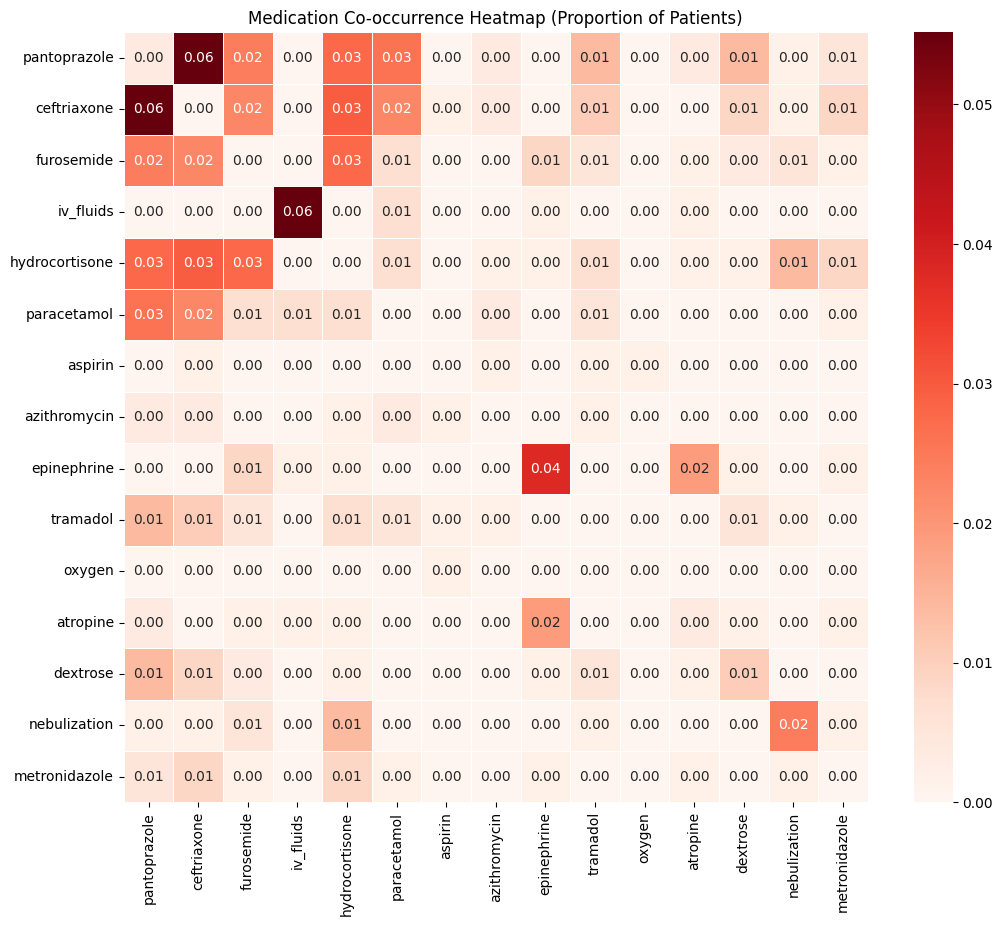

<Figure size 640x480 with 0 Axes>

In [ ]:

# Co-occurrence Analysis

all_pairs = Counter()
for meds in df['treatment_list_nlp']:
    all_pairs.update(combinations(sorted(meds), 2))

top_pairs = all_pairs.most_common(10)
print("\nTop 10 Co-prescribed Medication Pairs:")
for pair, count in top_pairs:
    print(f"{pair[0]} + {pair[1]}: {count} patients")

# Heatmap for top 15 medications
med_counts = Counter([m for sublist in df['treatment_list_nlp'] for m in sublist])
top_meds = [med for med, _ in med_counts.most_common(15)]

co_matrix = pd.DataFrame(0, index=top_meds, columns=top_meds)
for meds in df['treatment_list_nlp']:
    meds = [m for m in meds if m in top_meds]
    for a, b in combinations(meds, 2):
        co_matrix.loc[a, b] += 1
        co_matrix.loc[b, a] += 1

co_matrix_prop = co_matrix / len(df)

plt.figure(figsize=(12,10))
sns.heatmap(co_matrix_prop, cmap='Reds', linewidths=0.5, annot=True, fmt=".2f")
plt.title("Medication Co-occurrence Heatmap (Proportion of Patients)")
plt.show()


plt.savefig(
    "medication cooccurrence healtmap.png",
    dpi=300,
    bbox_inches="tight"
)



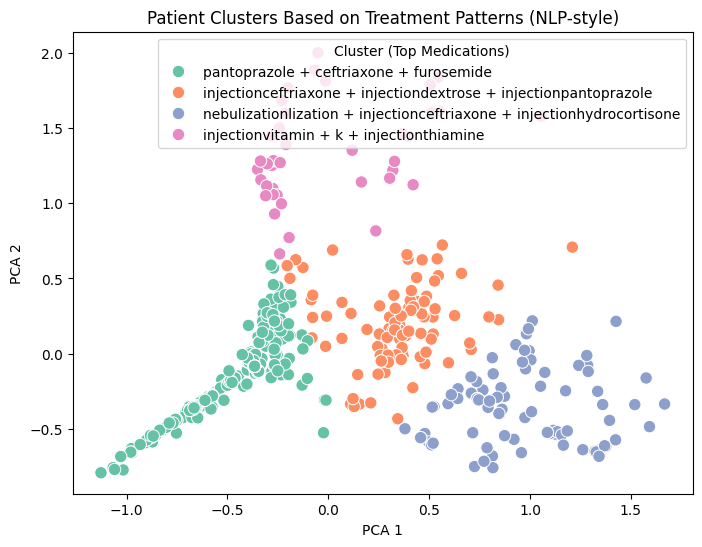

In [ ]:

# Medication Clustering

mlb = MultiLabelBinarizer()
X_meds = mlb.fit_transform(df['treatment_list_nlp'])

#  Dimensionality Reduction

# Reduce to 2 dimensions for visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_meds)

# K-Means Clustering
kmeans = KMeans(n_clusters=4, random_state=42)
df['cluster'] = kmeans.fit_predict(X_pca)

# Create descriptive cluster labels (top 3 meds)
cluster_labels = {}
for clust in range(4):
    top_meds_cluster = pd.DataFrame(X_meds, columns=mlb.classes_)[df['cluster']==clust].mean().sort_values(ascending=False).head(3)
    meds_clean = [m for m in top_meds_cluster.index if m.strip()]
    cluster_labels[clust] = " + ".join(meds_clean)
df['cluster_label'] = df['cluster'].map(cluster_labels)

# Scatterplot
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df['cluster_label'], palette="Set2", s=80)
plt.title("Patient Clusters Based on Treatment Patterns (NLP-style)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Cluster (Top Medications)")
plt.show()


Top words in Chief Complaints:
['abdominal' 'ache' 'active' 'acute' 'aggresive' 'altered' 'appetite'
 'assualt' 'behaviour' 'bleed' 'bleeding' 'body' 'breath' 'breathing'
 'burn' 'burning' 'cessation' 'chest' 'consciousness' 'cough']


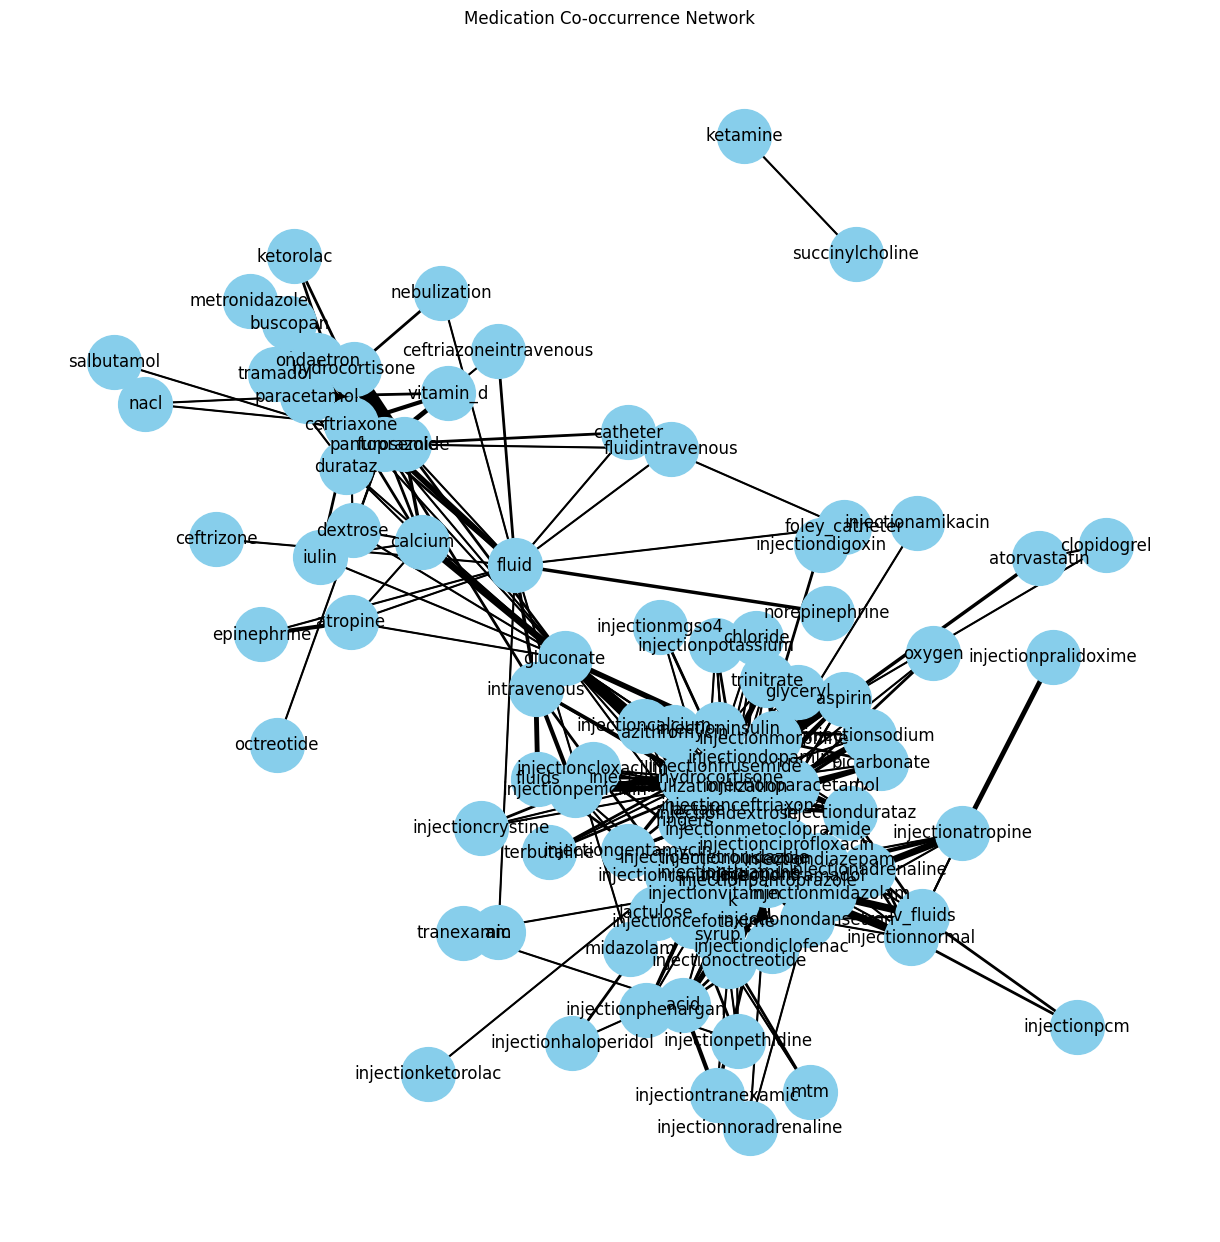

In [ ]:
# NLP on Chief Complaints

vectorizer = CountVectorizer(stop_words='english', min_df=2)
X_complaints = vectorizer.fit_transform(df['Chief Complain'].fillna(''))
print("\nTop words in Chief Complaints:")
print(vectorizer.get_feature_names_out()[:20])


# Network Graph of Medications
#
G = nx.Graph()
for meds, count in all_pairs.items():
    if count > 2:  # threshold to reduce clutter
        G.add_edge(meds[0], meds[1], weight=count)

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k=0.5)
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=1500, font_size=12)
edges = G.edges()
weights = [G[u][v]['weight'] for u,v in edges]
nx.draw_networkx_edges(G, pos, edgelist=edges, width=[w/2 for w in weights])
plt.title("Medication Co-occurrence Network")
plt.show()

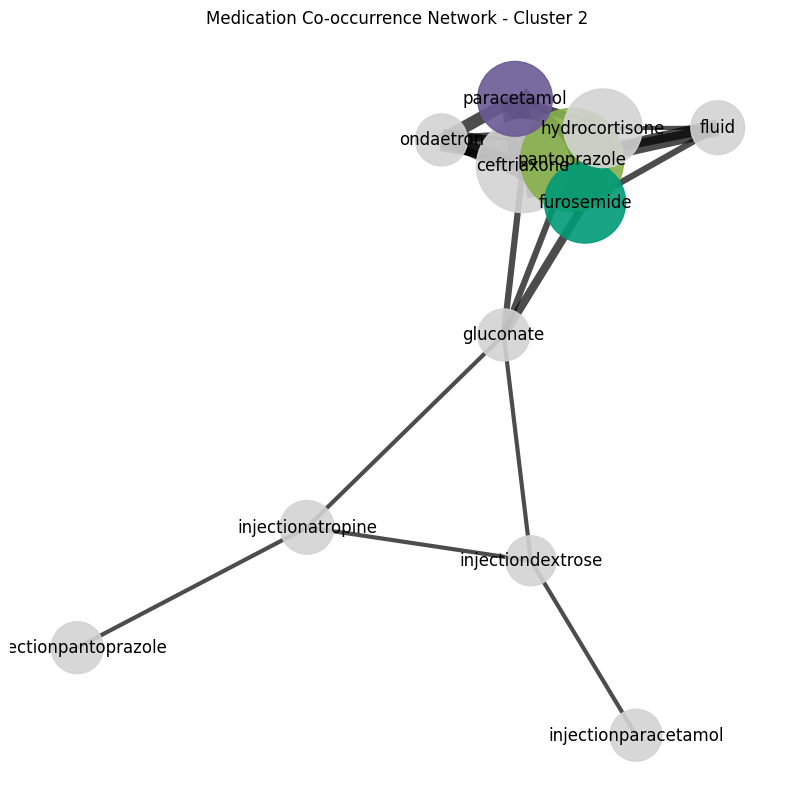

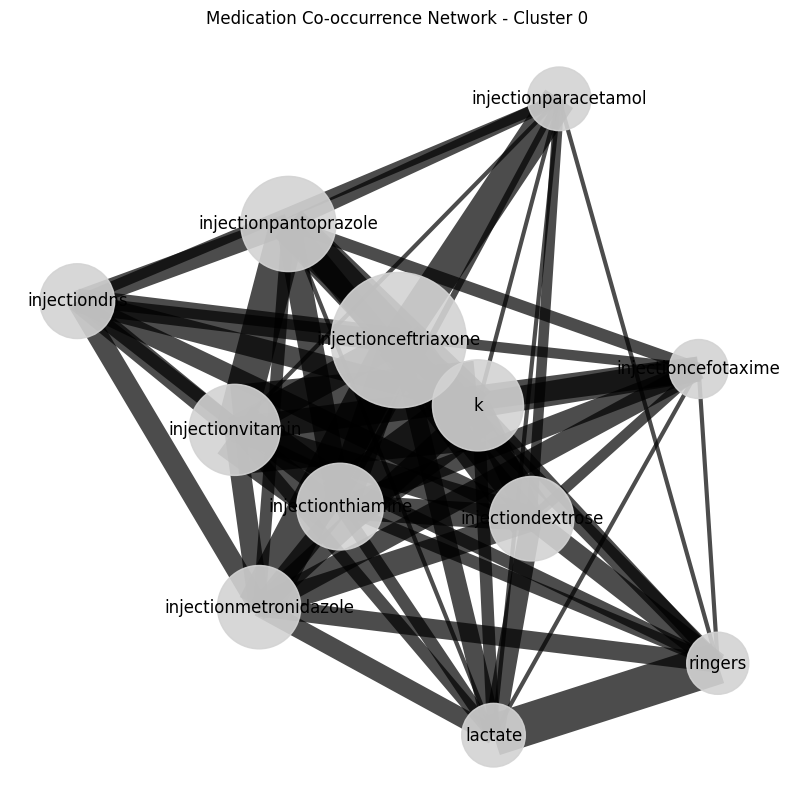

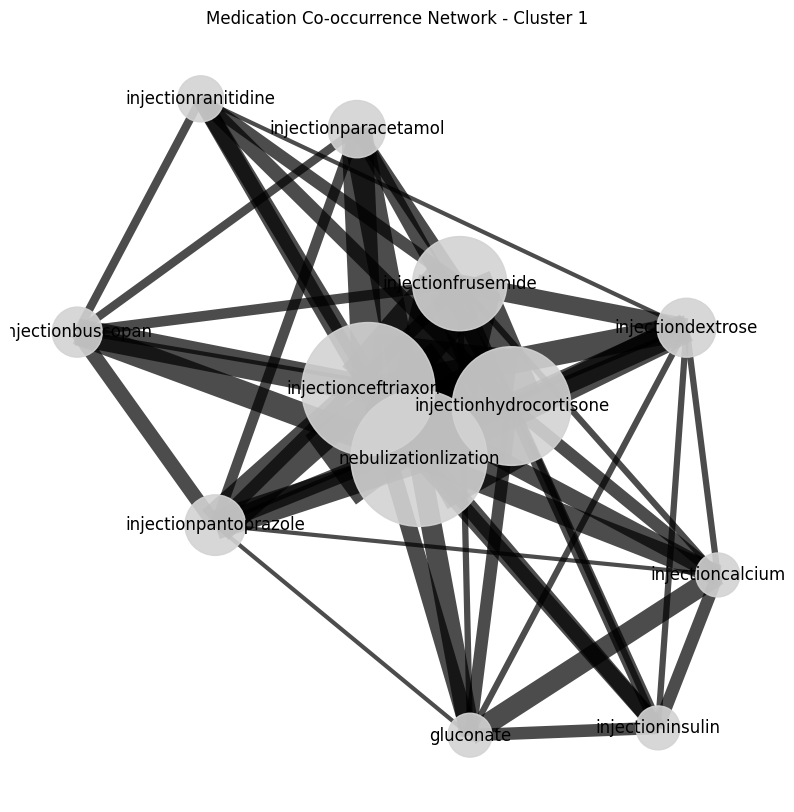

In [ ]:
# Graph bettering for interactive only.

# Step 1: Drug Classes (for coloring)

drug_classes = {
    "paracetamol": "Analgesic",
    "tramadol": "Analgesic",
    "pantoprazole": "GI",
    "iv_fluids": "Fluids",
    "ringer_lactate": "Fluids",
    "furosemide": "Diuretic",
    "vancomycin": "Antibiotic",
    "ciprofloxacin": "Antibiotic",
    "metronidazole": "Antibiotic",
    "ranitidine": "GI",
    "vitamin_d": "Vitamin",
    "aspirin": "Cardio",
    # add more as needed
}

class_colors = {
    "Antibiotic": "#FF6F61",
    "Analgesic": "#6B5B95",
    "GI": "#88B04B",
    "Fluids": "#FFA500",
    "Diuretic": "#009B77",
    "Vitamin": "#F7CAC9",
    "Cardio": "#92A8D1",
    "Other": "#D3D3D3"
}


# Cluster Patients by Treatments

mlb = MultiLabelBinarizer()
X_meds = mlb.fit_transform(df['treatment_list_nlp'])

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_meds)

kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(X_pca)


# Step 3: Network Graph Function (Cluster-specific)
# -------------------------------
def plot_med_network(df_cluster, top_n=15, threshold=2, cluster_name="Cluster"):
    # Count co-occurrences
    all_pairs = Counter()
    for meds in df_cluster['treatment_list_nlp']:
        meds = [m for m in meds if m]
        all_pairs.update(combinations(sorted(meds), 2))

    # Top N medications
    med_counts = Counter([m for sublist in df_cluster['treatment_list_nlp'] for m in sublist])
    top_meds = [med for med, _ in med_counts.most_common(top_n)]

    # Build graph
    G = nx.Graph()
    for (a, b), count in all_pairs.items():
        if count >= threshold and a in top_meds and b in top_meds:
            G.add_edge(a, b, weight=count)

    plt.figure(figsize=(10,10))
    pos = nx.spring_layout(G, k=0.5, seed=42)

    # Node sizes proportional to frequency
    node_sizes = [med_counts[node]*100 for node in G.nodes()]

    # Node colors by drug class
    node_colors = [class_colors.get(drug_classes.get(node, "Other"), "#D3D3D3") for node in G.nodes()]

    # Edge widths proportional to co-occurrence
    edges = G.edges()
    weights = [G[u][v]['weight']*1.5 for u,v in edges]

    # Draw nodes and edges
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, alpha=0.9)
    nx.draw_networkx_labels(G, pos, font_size=12)
    nx.draw_networkx_edges(G, pos, edgelist=edges, width=weights, alpha=0.7)

    plt.title(f"Medication Co-occurrence Network - {cluster_name}")
    plt.axis('off')
    plt.show()

# -------------------------------
# Step 4: Plot Networks for Each Cluster
# -------------------------------
for clust in df['cluster'].unique():
    df_clust = df[df['cluster']==clust]
    plot_med_network(df_clust, top_n=12, threshold=2, cluster_name=f"Cluster {clust}")


In [ ]:
def plot_med_network_clean(
    df_cluster,
    top_n=12,
    min_edge_weight=3,
    label_top_k=8,
    cluster_name="Cluster",
    export=False
):

    # Co-occurrence counting

    all_pairs = Counter()
    for meds in df_cluster['treatment_list_nlp']:
        meds = list(set(meds))
        all_pairs.update(combinations(sorted(meds), 2))

    med_counts = Counter(
        med for meds in df_cluster['treatment_list_nlp'] for med in meds
    )

    top_meds = set(med for med, _ in med_counts.most_common(top_n))


    # Build Graph
    # -----------------------------
    G = nx.Graph()

    for (a, b), w in all_pairs.items():
        if a in top_meds and b in top_meds and w >= min_edge_weight:
            G.add_edge(a, b, weight=w)

    G.remove_nodes_from(list(nx.isolates(G)))

    # -----------------------------
    # ADD ATTRIBUTES (for Gephi)

    for n in G.nodes():
        G.nodes[n]["frequency"] = med_counts[n]
        G.nodes[n]["drug_class"] = drug_classes.get(n, "Other")
        G.nodes[n]["cluster"] = cluster_name


    # PLOT (unchanged)
    # -----------------------------
    pos = nx.spring_layout(G, k=1.2, iterations=120, seed=42)

    node_sizes = [med_counts[n] * 250 for n in G.nodes()]
    node_colors = [
        class_colors.get(drug_classes.get(n, "Other"), "#D3D3D3")
        for n in G.nodes()
    ]

    edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
    max_w = max(edge_weights) if edge_weights else 1
    edge_widths = [(w / max_w) * 5 for w in edge_weights]

    plt.figure(figsize=(11, 11))
    nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.35)
    nx.draw_networkx_nodes(
        G, pos,
        node_size=node_sizes,
        node_color=node_colors,
        edgecolors="black",
        linewidths=0.8
    )

    top_labels = dict(med_counts.most_common(label_top_k))
    labels = {n: n for n in G.nodes() if n in top_labels}
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=11)

    plt.title(f"Medication Co-occurrence Network – {cluster_name}")
    plt.axis("off")
    plt.show()

    # -----------------------------
    # RETURN GRAPH
    # -----------------------------
    return G


Cluster 1 represents an acute inpatient treatment pattern centered on infection and respiratory management, with ceftriaxone, hydrocortisone, nebulization, and frusemide as core co-prescribed therapies, supported by symptomatic and preventive medications.

In [ ]:
def plot_med_network_clean(
    df_cluster,
    top_n=12,
    min_edge_weight=3,
    label_top_k=8,
    cluster_name="Cluster",
    export=False
):
    # -----------------------------
    # Co-occurrence counting
    # -----------------------------
    all_pairs = Counter()
    for meds in df_cluster['treatment_list_nlp']:
        meds = list(set(meds))
        all_pairs.update(combinations(sorted(meds), 2))

    med_counts = Counter(
        med for meds in df_cluster['treatment_list_nlp'] for med in meds
    )

    top_meds = set(med for med, _ in med_counts.most_common(top_n))

    # -----------------------------
    # Build Graph
    # -----------------------------
    G = nx.Graph()

    for (a, b), w in all_pairs.items():
        if a in top_meds and b in top_meds and w >= min_edge_weight:
            G.add_edge(a, b, weight=w)

    G.remove_nodes_from(list(nx.isolates(G)))

    # -----------------------------
    # ADD ATTRIBUTES (for Gephi)
    # -----------------------------
    for n in G.nodes():
        G.nodes[n]["frequency"] = med_counts[n]
        G.nodes[n]["drug_class"] = drug_classes.get(n, "Other")
        G.nodes[n]["cluster"] = cluster_name

    # -----------------------------
    # PLOT (unchanged)
    # -----------------------------
    pos = nx.spring_layout(G, k=1.2, iterations=120, seed=42)

    node_sizes = [med_counts[n] * 250 for n in G.nodes()]
    node_colors = [
        class_colors.get(drug_classes.get(n, "Other"), "#D3D3D3")
        for n in G.nodes()
    ]

    edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
    max_w = max(edge_weights) if edge_weights else 1
    edge_widths = [(w / max_w) * 5 for w in edge_weights]

    plt.figure(figsize=(11, 11))
    nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.35)
    nx.draw_networkx_nodes(
        G, pos,
        node_size=node_sizes,
        node_color=node_colors,
        edgecolors="black",
        linewidths=0.8
    )

    top_labels = dict(med_counts.most_common(label_top_k))
    labels = {n: n for n in G.nodes() if n in top_labels}
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=11)

    plt.title(f"Medication Co-occurrence Network – {cluster_name}")
    plt.axis("off")
    plt.show()

    # -----------------------------
    # RETURN GRAPH
    # -----------------------------
    return G


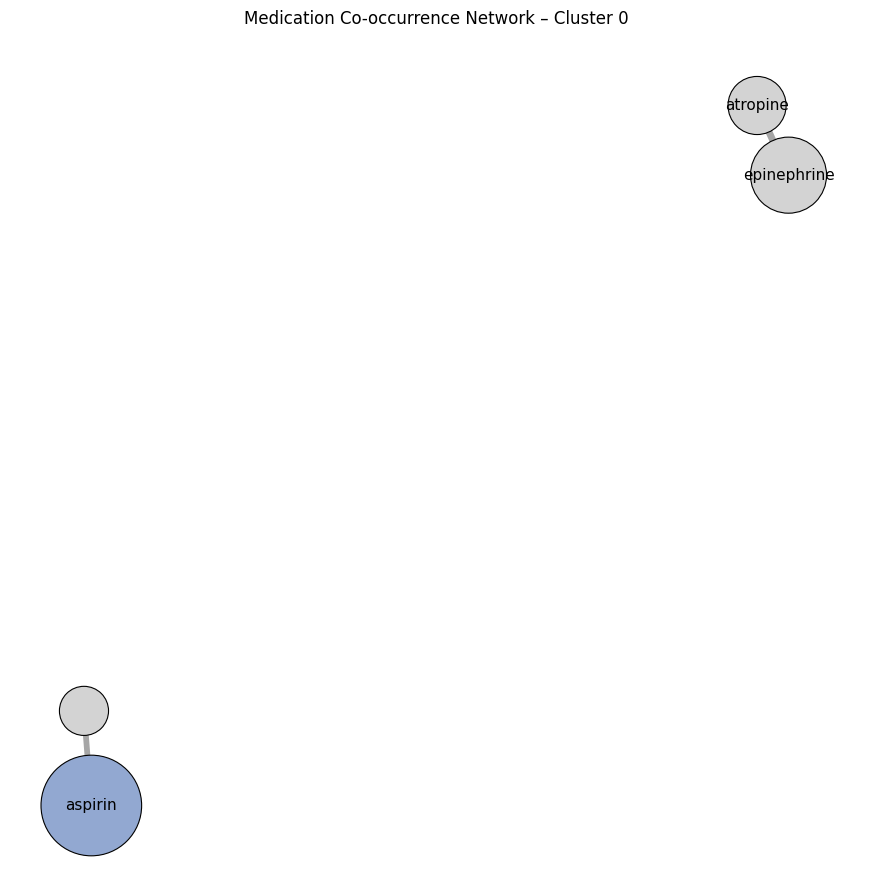

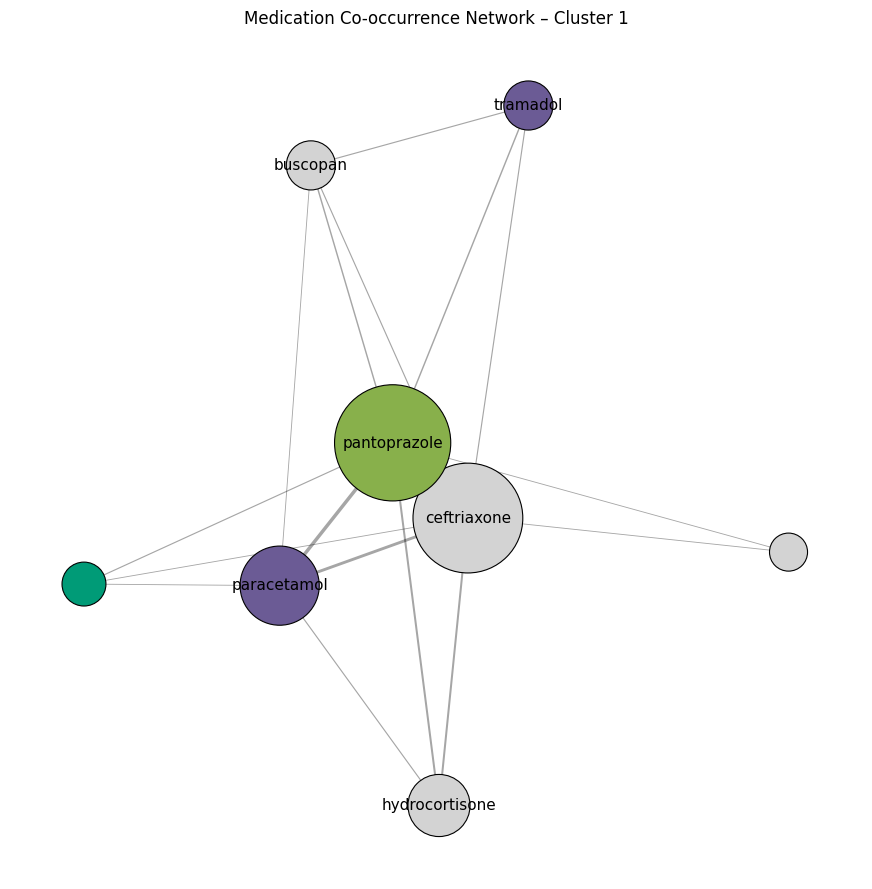

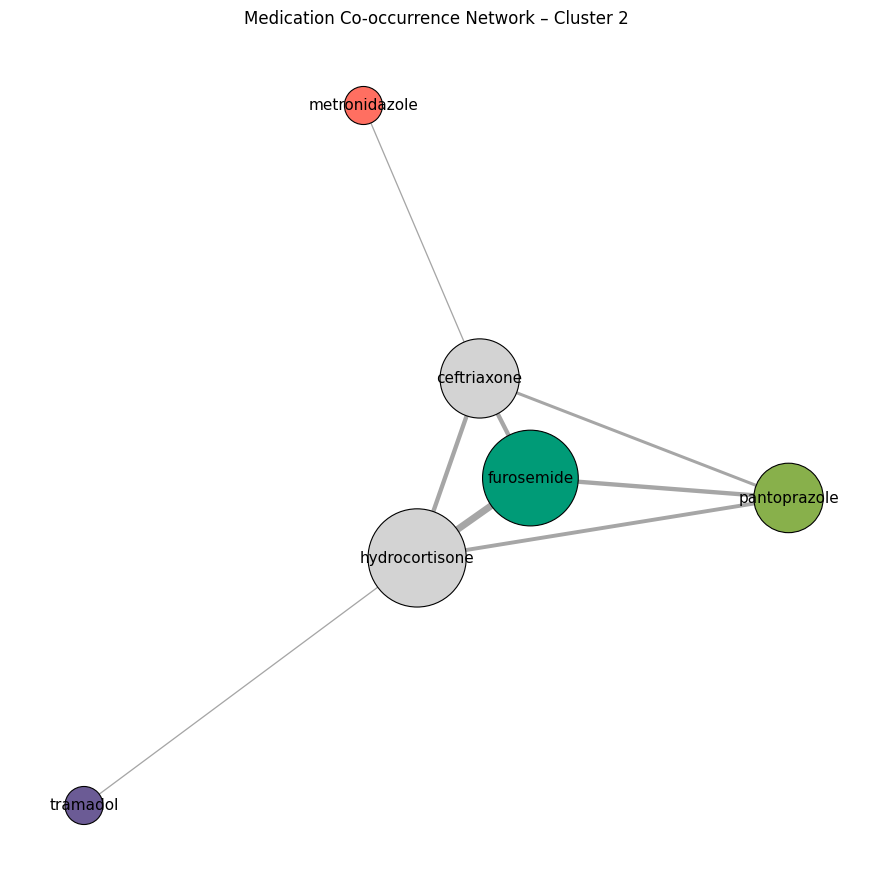

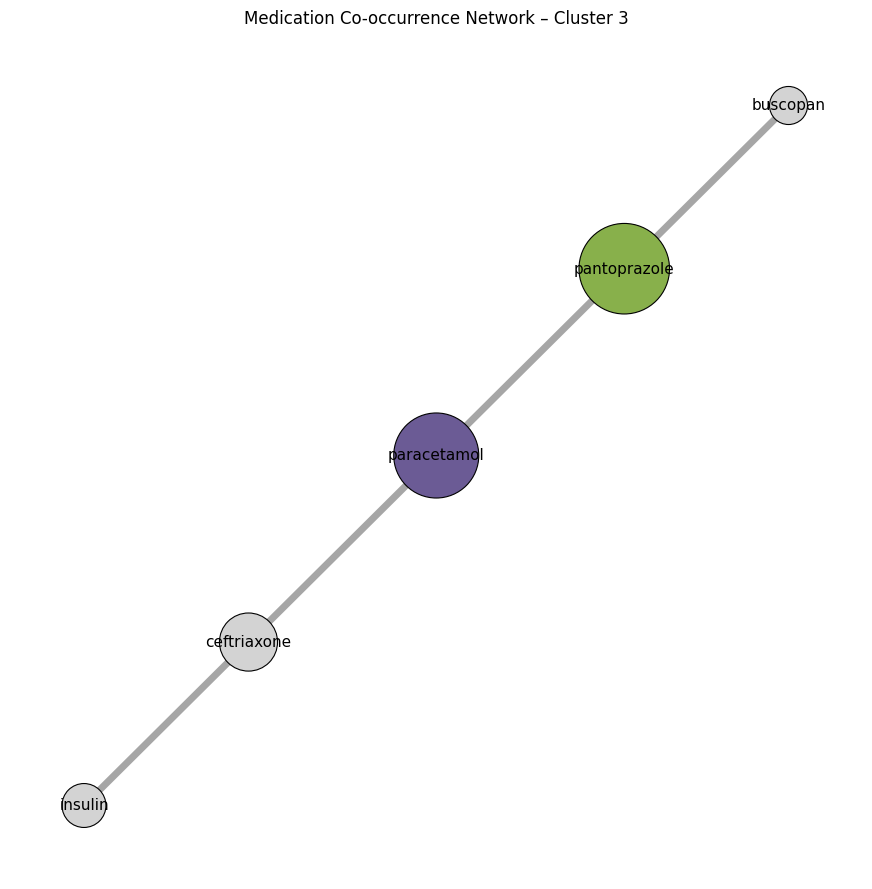

In [ ]:
for clust in sorted(df["cluster"].unique()):
    df_clust = df[df["cluster"] == clust]

    G = plot_med_network_clean(
        df_clust,
        top_n=12,
        min_edge_weight=3,
        label_top_k=7,
        cluster_name=f"Cluster {clust}"
    )

    nx.write_gexf(
        G,
        f"med_cooccurrence_cluster_{clust}.gexf"
    )


Top Co-prescribed Medications:
                   Medication Pair  Patient Count
0      (ceftriaxone, pantoprazole)             32
1    (ceftriaxone, hydrocortisone)             17
2   (hydrocortisone, pantoprazole)             16
3     (furosemide, hydrocortisone)             16
4           (iv_fluids, iv_fluids)             16
5      (pantoprazole, paracetamol)             15
6       (furosemide, pantoprazole)             14
7       (ceftriaxone, paracetamol)             13
8        (ceftriaxone, furosemide)             13
9          (atropine, epinephrine)             11
10      (epinephrine, epinephrine)             11
11        (buscopan, pantoprazole)              9
12        (pantoprazole, tramadol)              8
13        (dextrose, pantoprazole)              8
14  (hydrocortisone, nebulization)              8


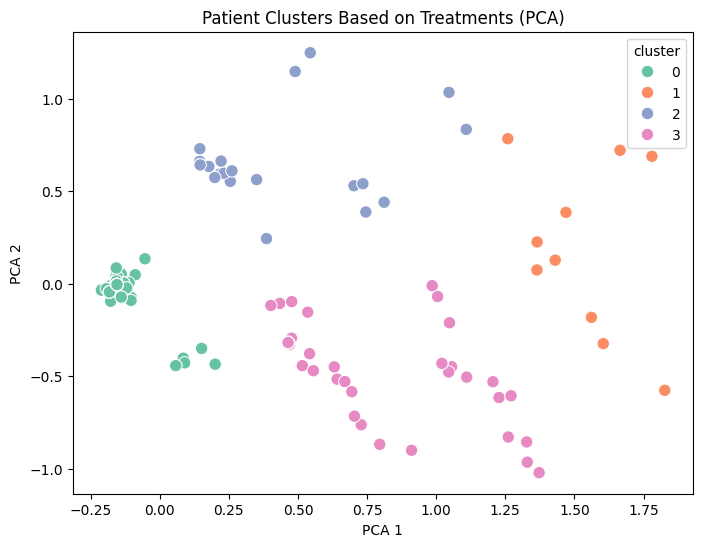

Top Complaints per Medication:
                 Medication                                     Top Complaints
0                                                                   poisoining
1                 adenosine                            abdominal pain, dyspnea
2   amoxicillin_clavulanate     altered consciousness neurological, poisoining
3                   aspirin  fever, altered consciousness neurological, abd...
4              atorvastatin  fever, ugi bleed, altered consciousness neurol...
5                  atropine  altered consciousness neurological, poisoining...
6              azithromycin  dyspnea, fever, altered consciousness neurolog...
7                  buscopan                    dyspnea, fever, epigastric pain
8                cefotaxime                    yellowish discoloration of body
9               ceftriaxone  dyspnea, fever, altered consciousness neurolog...
10              clopidogrel  ugi bleed, altered consciousness neurological,...
11                 de

In [ ]:

replacements = {
    # Antibiotics
    "ceftraxone": "ceftriaxone",
    "ceftriazone": "ceftriaxone",
    "cefotaxime": "cefotaxime",
    "flucloxacillin": "flucloxacillin",
    "amoxyclav": "amoxicillin_clavulanate",
    "vancomycin": "vancomycin",
    "levofloxacin": "levofloxacin",
    "clindamycin": "clindamycin",
    "penicillin": "penicillin",
    "cloxacillin": "cloxacillin",
    "gentamycin": "gentamicin",
    "metronidazole": "metronidazole",
    "ciprofloxacin": "ciprofloxacin",
    "roxithromycin": "roxithromycin",
    "doxycycline": "doxycycline",
    "azithromycin": "azithromycin",
    # GI / Anti-ulcer
    "pantaprazole": "pantoprazole",
    "pantop": "pantoprazole",
    "ondetron": "ondansetron",
    "ondeetron": "ondansetron",
    "ondeon": "ondansetron",
    "ranitidine": "ranitidine",
    "omeprazole": "omeprazole",
    "octreotide": "octreotide",
    "domperidome": "domperidone",
    "metoclopromide": "metoclopramide",
    # Analgesics / Antipyretics
    "pcm": "paracetamol",
    "paracetamold": "paracetamol",
    "tramadol": "tramadol",
    "ketorolac": "ketorolac",
    "morphine": "morphine",
    "pethidine": "pethidine",
    "diclofenac": "diclofenac",
    # Fluids / Electrolytes
    "frusemide": "furosemide",
    "lasix": "furosemide",
    "rll": "ringer_lactate",
    "rl": "ringer_lactate",
    "ringer_lactate": "ringer_lactate",
    "dextrose": "dextrose",
    "ivfluid": "iv_fluids",
    "ivfluids": "iv_fluids",
    "ns": "iv_fluids",
    "normal": "iv_fluids",
    "saline": "iv_fluids",
    "ampules": "",
    # Cardiovascular
    "adrenaline": "epinephrine",
    "noradrenaline": "norepinephrine",
    "labetolol": "labetalol",
    "metoprolol": "metoprolol",
    "verapamil": "verapamil",
    "adenosine": "adenosine",
    "aspirin": "aspirin",
    "clopidogrel": "clopidogrel",
    "atorvastatin": "atorvastatin",
    "glyceryl_trinitrate": "glyceryl_trinitrate",
    # Sedatives / Muscle relaxants
    "diazepam": "diazepam",
    "lorazepam": "lorazepam",
    "midazolam": "midazolam",
    "ketamine": "ketamine",
    "succinylcholine": "succinylcholine",
    "vecuronium": "vecuronium",
    "levetiracetam": "levetiracetam",
    # Corticosteroids / Hormones
    "hydrocort": "hydrocortisone",
    "hydrocortisone": "hydrocortisone",
    "prednisolone": "prednisolone",
    "thiamine": "thiamine",
    "vitamin_k": "vitamin_k",
    "insulin": "insulin",
    # Others
    "atropine": "atropine",
    "pralidoxime": "pralidoxime",
    "terbutaline": "terbutaline",
    "salbutamol": "salbutamol",
    "iulin": "insulin",
    "optineuron": "optineuron",
    "activated_charcoal": "activated_charcoal",
    "oxygen": "oxygen",
    "silver_sulfadiazine": "silver_sulfadiazine",
    "buscopan": "buscopan",
    "foleys": "foley_catheter",
    "nebulationlisation": "nebulization",
    "nebulation": "nebulization",
    "none": ""
}

# -------------------------------
# 2. Medication cleaning function
# -------------------------------
def clean_med_text(text):
    text = str(text).lower()
    text = text.replace("-", " ").replace("_", " ")
    text = "".join(c if c.isalnum() or c=="," else " " for c in text)
    meds = [replacements.get(w.strip(), w.strip()) for w in text.split(",") if w.strip()]
    # Keep only known meds
    known_meds = set(replacements.values())
    meds = [m for m in meds if m in known_meds]
    return meds

df['treatment_list_nlp'] = df['treatment_raw'].apply(clean_med_text)


# 3. Normalize Chief Complaints (phrase-level)

def clean_complaint(text):
    if pd.isna(text):
        return ""
    text = text.lower()
    text = text.replace("/", " ").replace(",", " ").replace("-", " ")
    text = " ".join(text.split())
    return text

df['Chief_Complain_clean'] = df['Chief Complain'].apply(clean_complaint)

# Map common phrases to standard clinical terms
phrase_map = {
    "shortness of breath": "dyspnea",
    "breath shortness": "dyspnea",
    "abdominal pain distension": "abdominal pain",
    "yellowish discoloration of skin": "jaundice",
    "altered consciousness": "altered consciousness",
    "fever": "fever",
    "generalized swelling": "edema",
    "physical assault": "trauma"
}

def map_phrases(text):
    for k, v in phrase_map.items():
        text = text.replace(k, v)
    return text

df['Chief_Complain_norm'] = df['Chief_Complain_clean'].apply(map_phrases)

# -------------------------------
# 4. MultiLabelBinarizer for medication analysis
# -------------------------------
mlb = MultiLabelBinarizer()
X_meds = mlb.fit_transform(df['treatment_list_nlp'])
med_df = pd.DataFrame(X_meds, columns=mlb.classes_)

# -------------------------------
# 5. Co-prescription table
# -------------------------------
all_pairs = Counter()
for meds in df['treatment_list_nlp']:
    all_pairs.update(combinations(sorted(meds), 2))

co_df = pd.DataFrame(all_pairs.items(), columns=['Medication Pair', 'Patient Count'])
co_df = co_df.sort_values('Patient Count', ascending=False).reset_index(drop=True)
print("Top Co-prescribed Medications:")
print(co_df.head(15))

# 6. Patient clustering

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_meds)
kmeans = KMeans(n_clusters=4, random_state=42)
df['cluster'] = kmeans.fit_predict(X_pca)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df['cluster'], palette="Set2", s=80)
plt.title("Patient Clusters Based on Treatments (PCA)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()


# 7. Top complaints per medication

top_complaints = []
for med in mlb.classes_:
    complaints = df[df['treatment_list_nlp'].apply(lambda x: med in x)]['Chief_Complain_norm'].dropna()
    if len(complaints) == 0:
        continue
    common_phrases = Counter(complaints).most_common(3)
    top_phrases = [w for w, _ in common_phrases]
    top_complaints.append({'Medication': med, 'Top Complaints': ", ".join(top_phrases)})

complaints_df = pd.DataFrame(top_complaints).sort_values("Medication").reset_index(drop=True)
print("Top Complaints per Medication:")
print(complaints_df.head(25))


# 8. Interactive medication network (optional)

def plot_med_network_interactive(df_cluster, top_n=15, threshold=2, cluster_name="Cluster"):
    med_counts = Counter([m for sublist in df_cluster['treatment_list_nlp'] for m in sublist])
    top_meds = [med for med, _ in med_counts.most_common(top_n)]
    # Build co-occurrence graph
    all_pairs = Counter()
    for meds in df_cluster['treatment_list_nlp']:
        meds = [m for m in meds if m]
        all_pairs.update(combinations(sorted(meds), 2))
    G = nx.Graph()
    for (a,b), count in all_pairs.items():
        if count >= threshold and a in top_meds and b in top_meds:
            G.add_edge(a, b, weight=count)
    net = Network(height="700px", width="100%", notebook=True)
    net.force_atlas_2based()
    for node in G.nodes():
        size = med_counts[node]*10
        net.add_node(node, label=node, size=size, title=f"{node}: {med_counts[node]} patients")
    for u,v,data in G.edges(data=True):
        net.add_edge(u,v,value=data['weight'], title=f"Co-prescribed in {data['weight']} patients")
    net.show(f"{cluster_name}_med_network.html")
    print(f"Interactive network saved as {cluster_name}_med_network.html")

# Example for cluster 0
plot_med_network_interactive(df[df['cluster']==0], top_n=15, threshold=2, cluster_name="Cluster_0")


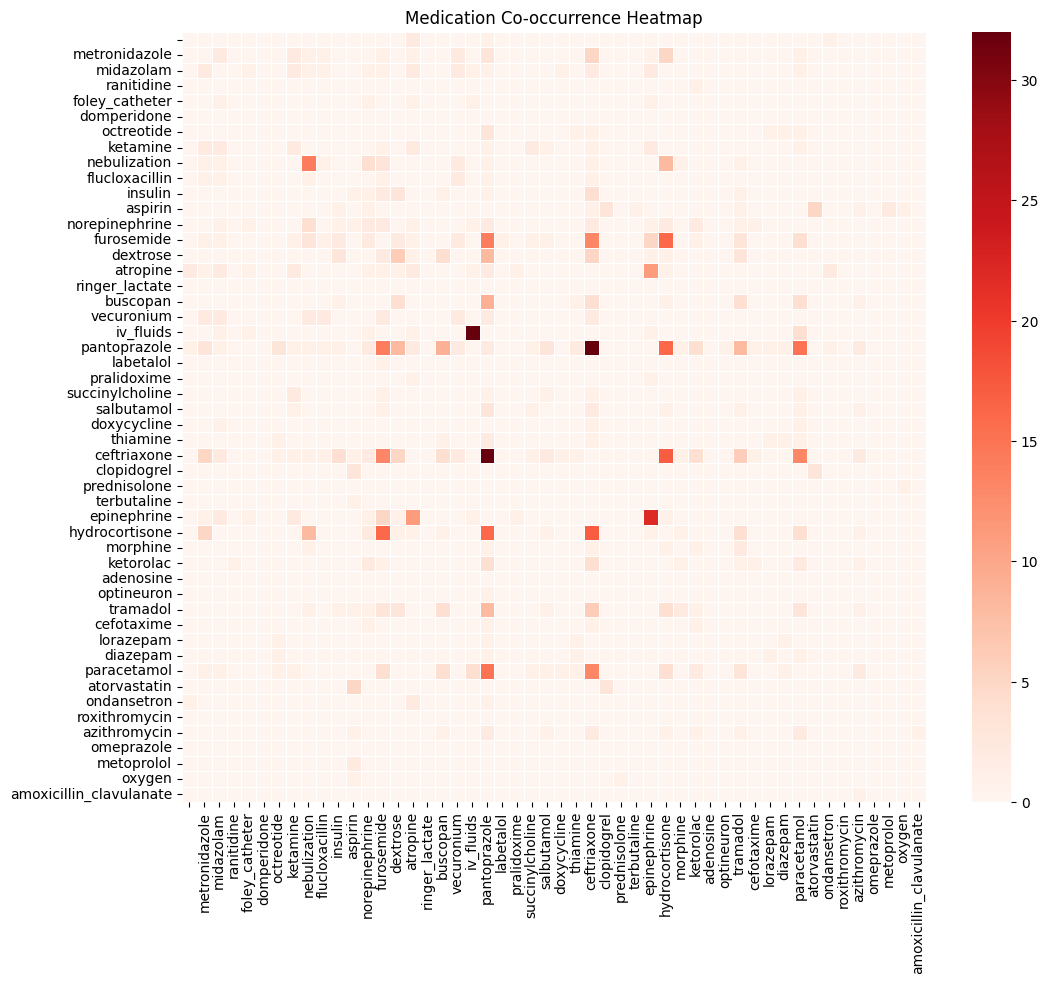

In [ ]:
# Build co-occurrence matrix
med_list = list(set([m for sublist in df['treatment_list_nlp'] for m in sublist]))
co_matrix = pd.DataFrame(0, index=med_list, columns=med_list)

for meds in df['treatment_list_nlp']:
    for a, b in combinations(meds, 2):
        co_matrix.loc[a, b] += 1
        co_matrix.loc[b, a] += 1

plt.figure(figsize=(12,10))
sns.heatmap(co_matrix, cmap='Reds', linewidths=0.5)
plt.title("Medication Co-occurrence Heatmap")
plt.show()


In [ ]:

# 1. Outcome mapping
# -------------------------------
outcome_mapping = {
    "Alive": 0,
    "Left Against Medical Advice": 1,
    "Within 7 Days Mortality": 2,
    "In-Hospital Mortality (>7 Days)": 3,
    "Ed Mortality": 4
}
df["outcome_class"] = df["Mortality"].map(outcome_mapping)


# 2. Medication presence & mortality

mlb = MultiLabelBinarizer()
X_meds = mlb.fit_transform(df['treatment_list_nlp'])
med_df = pd.DataFrame(X_meds, columns=mlb.classes_)
med_df['outcome'] = df['outcome_class'].values

# Count frequency of each medication
med_freq = med_df.drop(columns='outcome').sum().sort_values(ascending=False)

# Calculate mortality for each medication
mortality_df = med_df.groupby('outcome').mean().T  # mean proportion of patients per outcome
mortality_df.columns = [f"Outcome_{c}" for c in mortality_df.columns]


# 3. Top complaints per medication

top_complaints = []
for med in mlb.classes_:
    complaints = df[df['treatment_list_nlp'].apply(lambda x: med in x)]['Chief_Complain_norm'].dropna()
    if len(complaints) == 0:
        continue
    common_phrases = Counter(complaints).most_common(3)
    top_phrases = [w for w, _ in common_phrases]
    top_complaints.append({'Medication': med, 'Top_Complaints': ", ".join(top_phrases)})

complaints_df = pd.DataFrame(top_complaints)


# 4. Merge everything

summary_df = complaints_df.copy()
summary_df['Prescription_Freq'] = summary_df['Medication'].apply(lambda x: med_freq.get(x, 0))
summary_df = summary_df.merge(mortality_df, left_on='Medication', right_index=True, how='left')

# Sort by frequency
summary_df = summary_df.sort_values('Prescription_Freq', ascending=False).reset_index(drop=True)
print(summary_df.head(20))


        Medication                                     Top_Complaints  \
0     pantoprazole    dyspnea, fever, yellowish discoloration of body   
1      ceftriaxone  dyspnea, fever, altered consciousness neurolog...   
2       furosemide  dyspnea, altered consciousness neurological, f...   
3   hydrocortisone                              dyspnea, fever, cough   
4      paracetamol    fever, yellowish discoloration of body, dyspnea   
5          aspirin  fever, altered consciousness neurological, abd...   
6        iv_fluids     fever, abdominal pain, acute diarrheal illness   
7     azithromycin  dyspnea, fever, altered consciousness neurolog...   
8         tramadol                    dyspnea, fever, epigastric pain   
9           oxygen                  dyspnea, abdominal pain, vomiting   
10   metronidazole                   dyspnea, physical assualt, edema   
11        atropine  altered consciousness neurological, poisoining...   
12        buscopan                    dyspnea, feve

/tmp/ipython-input-2501236348.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Prescription_Freq', y='Medication', data=summary_df.head(10), palette="Blues_r")


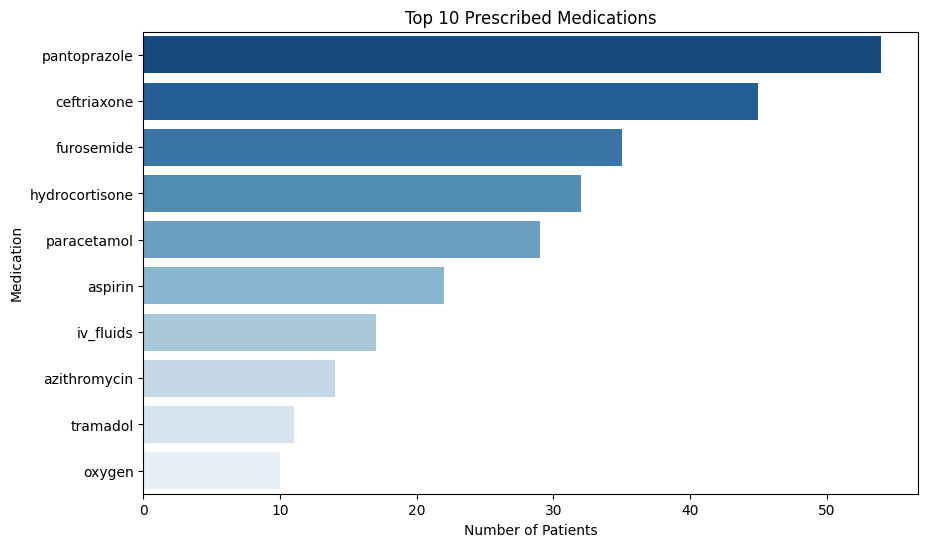

In [ ]:
# Plot figure

plt.figure(figsize=(10,6))
sns.barplot(x='Prescription_Freq', y='Medication', data=summary_df.head(10), palette="Blues_r")
plt.title("Top 10 Prescribed Medications")
plt.xlabel("Number of Patients")
plt.ylabel("Medication")
plt.show()


/tmp/ipython-input-557963469.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


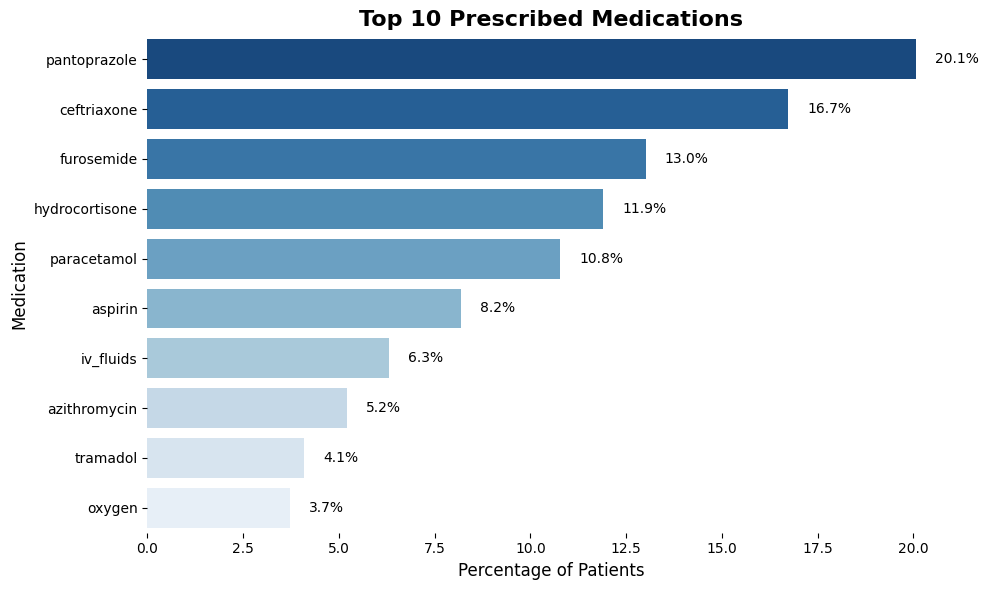

In [ ]:

# Take top 10 medications

top_meds = summary_df.sort_values(by="Prescription_Freq", ascending=False).head(10).copy()


# Compute percentage of total prescriptions

top_meds['Percentage'] = top_meds['Prescription_Freq'] / top_meds['Prescription_Freq'].sum() * 100


# Plot horizontal bar chart

plt.figure(figsize=(10,6))
ax = sns.barplot(
    x='Percentage',
    y='Medication',
    data=top_meds,
    palette="Blues_r"
)


# Add percentage labels

for i, (perc, med) in enumerate(zip(top_meds['Percentage'], top_meds['Medication'])):
    ax.text(
        perc + 0.5,  # small offset to the right of bar
        i,
        f"{perc:.1f}%",
        va='center',
        fontsize=10
    )


#  Titles and styling

plt.title("Top 10 Prescribed Medications", fontsize=16, fontweight='bold')
plt.xlabel("Percentage of Patients", fontsize=12)
plt.ylabel("Medication", fontsize=12)

sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()


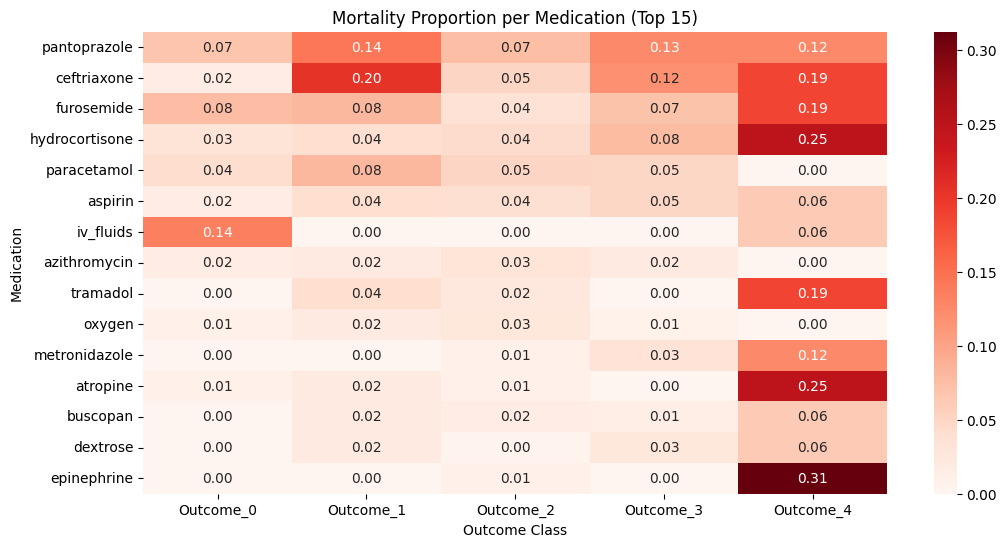

In [ ]:
# proportion plot

mortality_cols = [c for c in summary_df.columns if c.startswith('Outcome')]
plt.figure(figsize=(12,6))
sns.heatmap(summary_df[mortality_cols].head(15), annot=True, fmt=".2f", yticklabels=summary_df['Medication'].head(15), cmap='Reds')
plt.title("Mortality Proportion per Medication (Top 15)")
plt.xlabel("Outcome Class")
plt.ylabel("Medication")
plt.show()


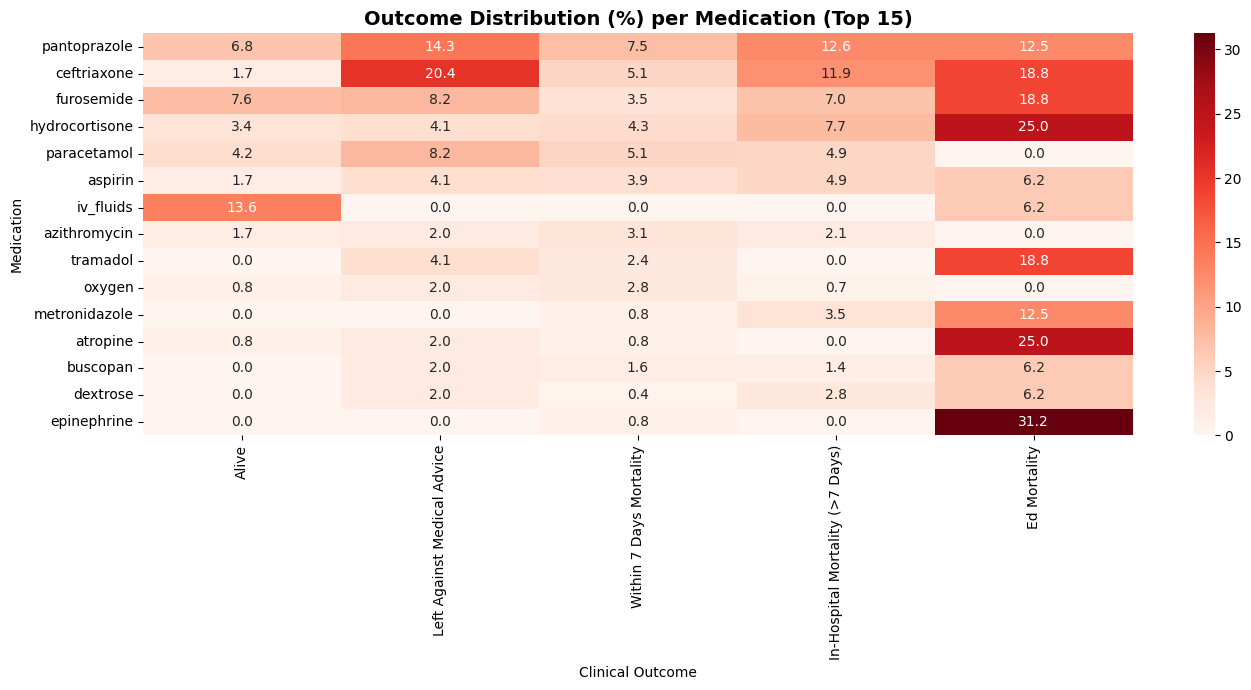

In [ ]:
# Reverse mapping: 0 -> Alive, etc.
reverse_outcome_map = {v: k for k, v in outcome_mapping.items()}

# Identify outcome columns
mortality_cols = [c for c in summary_df.columns if c.startswith("Outcome_")]

# Rename columns
rename_dict = {
    col: reverse_outcome_map[int(col.split("_")[1])]
    for col in mortality_cols
}

summary_df = summary_df.rename(columns=rename_dict)

outcome_labels = list(outcome_mapping.keys())

summary_df[outcome_labels] = summary_df[outcome_labels] * 100

plt.figure(figsize=(14,7))

sns.heatmap(
    summary_df[outcome_labels].head(15),
    annot=True,
    fmt=".1f",
    cmap="Reds",
    yticklabels=summary_df["Medication"].head(15)
)

plt.title("Outcome Distribution (%) per Medication (Top 15)", fontsize=14, fontweight="bold")
plt.xlabel("Clinical Outcome")
plt.ylabel("Medication")
plt.tight_layout()
plt.show()



In [ ]:
summary_df

Medication  \
0              pantoprazole   
1               ceftriaxone   
2                furosemide   
3            hydrocortisone   
4               paracetamol   
5                   aspirin   
6                 iv_fluids   
7              azithromycin   
8                  tramadol   
9                    oxygen   
10            metronidazole   
11                 atropine   
12                 buscopan   
13                 dextrose   
14              epinephrine   
15           norepinephrine   
16                ketorolac   
17                  insulin   
18               salbutamol   
19             nebulization   
20             atorvastatin   
21                midazolam   
22              terbutaline   
23                 ketamine   
24                labetalol   
25                lorazepam   
26              clopidogrel   
27                 diazepam   
28               octreotide   
29               metoprolol   
30                 thiamine   
31                 morphine   
32                adenosine   
33  amoxicillin_clavulanate   
34          succinylcholine   
35             prednisolone   
36           foley_catheter   
37           flucloxacillin   
38               cefotaxime   
39                            
40              doxycycline   
41              domperidone   
42               omeprazole   
43              pralidoxime   
44               optineuron   
45              ondansetron   
46               ranitidine   
47            roxithromycin   
48           ringer_lactate   
49               vecuronium   

                                       Top_Complaints  Prescription_Freq  \
0     dyspnea, fever, yellowish discoloration of body                 54   
1   dyspnea, fever, altered consciousness neurolog...                 45   
2   dyspnea, altered consciousness neurological, f...                 35   
3                               dyspnea, fever, cough                 32   
4     fever, yellowish discoloration of body, dyspnea                 29   
5   fever, altered consciousness neurological, abd...                 22   
6      fever, abdominal pain, acute diarrheal illness                 17   
7   dyspnea, fever, altered consciousness neurolog...                 14   
8                     dyspnea, fever, epigastric pain                 11   
9                   dyspnea, abdominal pain, vomiting                 10   
10                   dyspnea, physical assualt, edema                  9   
11  altered consciousness neurological, poisoining...                  8   
12                    dyspnea, fever, epigastric pain                  8   
13  altered consciousness neurological, dyspnea, a...                  7   
14  altered consciousness neurological, physical a...                  7   
15  abdominal pain, yellowish discoloration of bod...                  7   
16  abdominal pain, fall back injury, yellowish di...                  7   
17  altered consciousness neurological, chest pain...                  6   
18  fever, dyspnea, altered consciousness neurolog...                  6   
19                                            dyspnea                  5   
20  fever, ugi bleed, altered consciousness neurol...                  5   
21                   fever, physical assualt, dyspnea                  4   
22    dyspnea, yellowish discoloration of body, fever                  4   
23                   fever, physical assualt, dyspnea                  3   
24                       edema, fever, abdominal pain                  3   
25                      dyspnea, hematemesis pr bleed                  3   
26  ugi bleed, altered consciousness neurological,...                  3   
27  altered consciousness neurological, hematemesi...                  3   
28  hematemesis pr bleed, yellowish discoloration ...                  3   
29                              fever, abdominal pain                  2   
30                        hematemesis pr bleed, fever                  2   
31 

Each cell represents the percentage of patients receiving a given medication who experienced a specific clinical outcome.”

In [ ]:
from collections import Counter
import re


# Combine all top complaints into one list

all_complaints_text = " ".join(summary_df['Top_Complaints'].dropna())

# Optional: clean text (remove punctuation, lowercase)
all_complaints_text = re.sub(r"[^a-z\s]", "", all_complaints_text.lower())

# Split into words
words = all_complaints_text.split()

# Count frequency
word_counts = Counter(words)

# Display top 30 words
top_30_words = word_counts.most_common(30)
print("Top 30 Words in Chief Complaints:")
for word, freq in top_30_words:
    print(f"{word}: {freq}")


Top 30 Words in Chief Complaints:
dyspnea: 25
fever: 21
altered: 14
consciousness: 14
neurological: 14
pain: 14
abdominal: 11
of: 8
yellowish: 7
discoloration: 7
body: 7
bleed: 7
physical: 5
assualt: 5
hematemesis: 5
pr: 5
poisoining: 4
epigastric: 3
injury: 3
acute: 2
diarrheal: 2
illness: 2
edema: 2
hyperventilation: 2
fall: 2
back: 2
ugi: 2
cough: 1
vomiting: 1
chest: 1


Top 30 Terms in Chief Complaints:
dyspnea: 143
fever: 98
altered_consciousness_neurological: 50
abdominal_pain: 46
hematemesis_pr_bleed: 30
pain: 26
generalized: 20
edema: 18
injury: 17
weakness: 17
acute: 14
diarrheal: 14
illness: 14
epigastric: 13
fall: 13
back: 13
vomiting: 12
yellowish_discoloration_of_body: 11
poisoning: 9
cough: 9
poisioning: 8
chest: 7
decreased: 7
stool: 7
and: 6
appetite: 6
urinary: 6
tract: 5
infection: 5
difficulty: 5


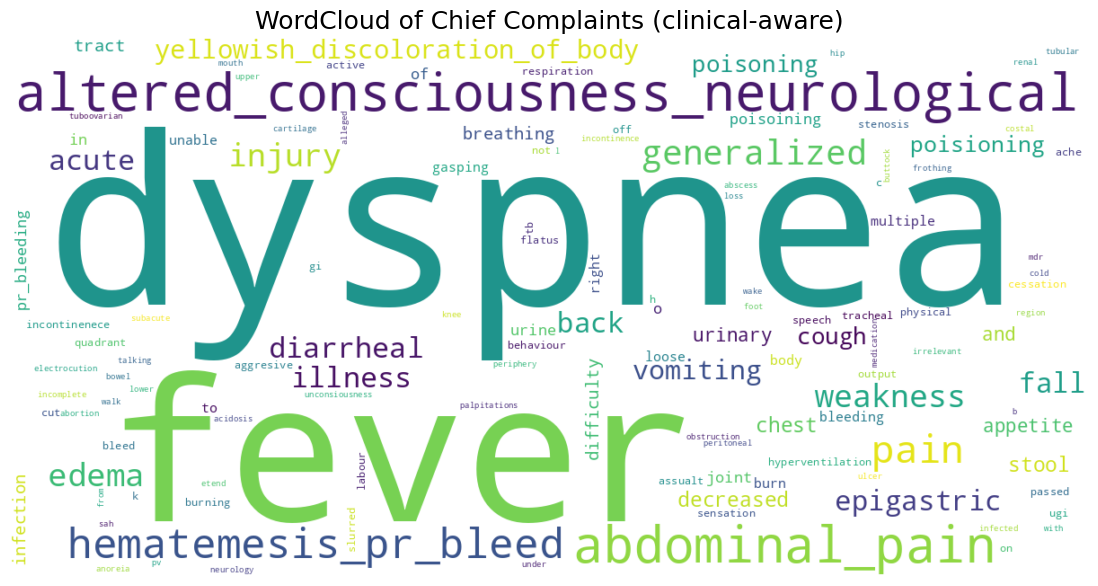

In [ ]:

# -------------------------------
# 1. Prepare chief complaints
# -------------------------------
# Assume 'Chief_Complain_norm' column exists
complaints_series = df['Chief_Complain_norm'].dropna().astype(str)

# Define common multi-word clinical terms to preserve
multi_word_terms = [
    "altered consciousness neurological",
    "abdominal pain",
    "pr bleed",
    "hematemesis pr",
    "neurological deficit",  # add more if relevant
    "yellowish discoloration of body",
]

# Preprocess complaints
all_terms = []
for comp in complaints_series:
    comp = comp.lower()
    # Remove unwanted characters
    comp = re.sub(r"[^a-z0-9\s]", "", comp)

    # Replace multi-word terms with underscored versions to keep them together
    for term in multi_word_terms:
        comp = comp.replace(term, term.replace(" ", "_"))

    # Split by whitespace
    words = comp.split()
    all_terms.extend(words)

# -------------------------------
# 2. Count frequencies
# -------------------------------
term_counts = Counter(all_terms)

# Show top 30
top_terms = term_counts.most_common(30)
print("Top 30 Terms in Chief Complaints:")
for term, count in top_terms:
    print(f"{term}: {count}")

# -------------------------------
# 3. Generate WordCloud
# -------------------------------
wordcloud = WordCloud(width=1200, height=600, background_color='white').generate_from_frequencies(term_counts)

plt.figure(figsize=(15,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud of Chief Complaints (clinical-aware)", fontsize=18)
plt.show()

# -------------------------------
# 4. Save figure
# -------------------------------
wordcloud.to_file("chief_complaints_wordcloud.png")


# Analysis of Emergency Room Treatment Patterns and Outcomes

## 1. Objective of the Analysis

The objective of this analysis is to systematically examine **treatment patterns administered in the Emergency Room (ER)** and to explore their **co-prescription behavior, patient grouping, and association with clinical outcomes**, including mortality.  
The analysis leverages **natural language processing (NLP)**, **unsupervised machine learning**, and **network analysis** to convert unstructured clinical text into actionable insights.

---

## 2. Data Loading and Initial Preparation

The dataset is loaded from a structured CSV file. The column describing treatments received in the ER is stored as **free-text**, which commonly contains missing values, abbreviations, spelling errors, and inconsistent formatting.

To ensure reliable processing:
- Missing values are replaced with empty strings.
- All entries are explicitly cast to string format.

This step ensures that downstream NLP operations do not fail due to null or inconsistent data types.

---

## 3. Medication Text Cleaning and Normalization

### What was done

A comprehensive medication normalization strategy was implemented, including:
- Conversion of text to lowercase
- Removal of non-alphabetic characters
- Standardization of spelling variations (e.g., *ceftraxone* → *ceftriaxone*)
- Expansion of abbreviations (e.g., *pcm* → *paracetamol*)
- Removal of non-medication tokens and administrative terms

A curated replacement dictionary was used to map raw tokens to **standardized medication names**.

### Why this was done

Clinical free-text medication data is inherently noisy. Without normalization:
- The same medication may appear under multiple names
- Frequency counts become fragmented
- Co-occurrence and clustering analyses become unreliable

Medication normalization is a **foundational requirement** in clinical NLP and pharmaco-epidemiology to ensure analytical validity.

---

## 4. Tokenization into Multi-Label Medication Lists

Each patient record often contains **multiple medications** administered simultaneously.  
Therefore, treatment data was tokenized into a **list of medications per patient**, rather than a single categorical value.

This transforms the problem into a **multi-label representation**, where each patient can be associated with multiple treatments.

This approach more accurately reflects real-world ER clinical practice.

---

## 5. Multi-Label Binarization of Treatments

The tokenized medication lists were converted into a binary feature matrix using a `MultiLabelBinarizer`.

- Rows represent individual patients
- Columns represent standardized medications
- Values indicate the presence (1) or absence (0) of a medication

This structured representation enables:
- Dimensionality reduction
- Clustering
- Outcome-based aggregation
- Network analysis

Binary encoding is preferred in treatment pattern analysis, as **medication presence** is more clinically relevant than frequency within a single encounter.

---

## 6. Clinical Outcome Encoding

Clinical outcomes were mapped to numeric classes to facilitate quantitative analysis.  
The mapping preserves increasing severity across outcome categories, ranging from survival to ER mortality.

Encoding outcomes numerically enables:
- Group-wise aggregation
- Visualization of treatment–outcome associations
- Comparison across patient subgroups

This step does not imply causality but enables structured exploratory analysis.

---

## 7. Medication Usage by Outcome Group

For each outcome category, the proportion of patients receiving each medication was calculated.

This provides insight into:
- Medications commonly used in severe cases
- Treatments prevalent among survivors
- Patterns of escalation in critically ill patients

This analysis is **descriptive in nature** and is used for hypothesis generation rather than causal inference.

---

## 8. Co-Occurrence Analysis of Medications

To understand treatment bundles commonly administered together, **pairwise co-occurrence counts** of medications were computed.

This identifies:
- Standard ER treatment combinations
- Protocol-driven medication bundles
- Frequently paired supportive therapies

The results were visualized using:
- Co-occurrence heatmaps
- Network graphs with weighted edges

Such analyses are widely used in **polypharmacy research** and **clinical pathway discovery**.

---

## 9. Dimensionality Reduction Using PCA

The high-dimensional medication matrix was projected into two dimensions using **Principal Component Analysis (PCA)**.

PCA captures the dominant patterns of variation in treatment administration while reducing noise and redundancy.

This step enables:
- Visualization of patient similarity
- Improved performance of clustering algorithms
- Interpretability of complex treatment data

---

## 10. Patient Clustering Based on Treatment Patterns

Unsupervised clustering (K-Means) was applied to the PCA-reduced data to identify **latent patient groups**.

Patients were grouped based on similarities in their treatment profiles, revealing:
- Distinct treatment phenotypes
- Potential clinical subgroups (e.g., infectious, cardiovascular, trauma-related)

This process is commonly referred to as **computational phenotyping** in clinical data science.

---

## 11. Medication Co-Occurrence Network Analysis

Medication relationships were further explored using **graph-based representations**:
- Nodes represent medications
- Edges represent co-prescription relationships
- Edge weights indicate co-occurrence frequency
- Node size reflects medication prevalence

Color-coding by drug class improves interpretability and highlights therapeutic categories.

Network analysis reveals **core medications**, **supportive treatments**, and **bridging drugs** across clinical contexts.

---

## 12. Natural Language Processing of Chief Complaints

Chief complaints were cleaned, normalized, and mapped to standardized clinical phrases.

This analysis provides contextual validation by linking:
- Presenting symptoms
- Administered treatments
- Observed outcomes

Phrase-level normalization improves interpretability and reduces linguistic variability common in ER documentation.

---

## 13. Integrated Summary and Outcome Visualization

A consolidated summary table was created, combining:
- Medication prescription frequency
- Common presenting complaints
- Outcome distribution percentages

Visualizations such as bar charts and heatmaps were used to:
- Highlight frequently prescribed medications
- Compare outcome distributions across treatments
- Support data-driven clinical interpretation

---

## 14. Key Strengths of the Approach

- Robust handling of noisy clinical text
- Appropriate use of multi-label representations
- Combination of NLP, clustering, and network analysis
- Emphasis on exploratory and descriptive analytics
- Visualization-driven insight generation

---

## 15. Limitations

- Observational data does not support causal inference
- Disease severity is a potential confounder
- Medication dosage and timing are not available
- Clustering assumptions may oversimplify clinical complexity
- Results may not generalize beyond the dataset context

---

## 16. Conclusion

This analysis demonstrates how **unstructured ER treatment and complaint data** can be transformed into structured, interpretable insights using **clinical NLP, unsupervised learning, and network analytics**.  
The approach supports exploratory clinical research, quality-of-care assessment, and hypothesis generation for future studies.


In [ ]:


# Ensure no missing text
df["chief_text"] = df["Chief_Complain_norm"].fillna("").str.lower()

# Minimal cleaning (DO NOT over-clean clinical text)
df["chief_text"] = df["chief_text"].apply(
    lambda x: re.sub(r"[^a-z\s]", " ", x)
)


In [ ]:


tfidf = TfidfVectorizer(
    stop_words="english",
    ngram_range=(1,2),
    min_df=5  # reduces noise
)

X = tfidf.fit_transform(df["chief_text"])
feature_names = tfidf.get_feature_names_out()


In [ ]:


mortality_terms = []

for idx, term in enumerate(feature_names):
    present = X[:, idx].toarray().ravel() > 0
    if present.sum() < 20:
        continue  # stability threshold

    mortality_rate = df.loc[present, "outcome_class"].isin([2,3,4]).mean()

    mortality_terms.append({
        "term": term,
        "cases": present.sum(),
        "mortality_rate": mortality_rate
    })

mortality_terms_df = pd.DataFrame(mortality_terms)
mortality_terms_df = mortality_terms_df.sort_values(
    "mortality_rate", ascending=False
)

mortality_terms_df.head(20)


term  cases  mortality_rate
14                          pr     34        0.852941
4                        bleed     32        0.843750
11              hematemesis pr     30        0.833333
15                    pr bleed     30        0.833333
10                 hematemesis     30        0.833333
3        altered consciousness     50        0.820000
5                consciousness     50        0.820000
2                      altered     50        0.820000
12                neurological     50        0.820000
6   consciousness neurological     50        0.820000
7                      dyspnea    143        0.720280
0                    abdominal     46        0.673913
1               abdominal pain     46        0.673913
13                        pain     72        0.652778
9                  generalized     20        0.650000
8                        fever     98        0.642857

In [ ]:
high_risk_terms = mortality_terms_df[
    (mortality_terms_df["cases"] > 50) &
    (mortality_terms_df["mortality_rate"] > 0.3)
]

high_risk_terms.head(5)


term  cases  mortality_rate
7   dyspnea    143        0.720280
13     pain     72        0.652778
8     fever     98        0.642857

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(
    n_components=5,
    random_state=42
)

lda_topics = lda.fit_transform(X)
df["complaint_topic"] = lda_topics.argmax(axis=1)


In [ ]:
def show_topics(model, feature_names, top_n=10):
    for idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-top_n-1:-1]]
        print(f"Topic {idx}: {', '.join(top_words)}")

show_topics(lda, feature_names)


Topic 0: fever, consciousness neurological, consciousness, altered consciousness, neurological, altered, poisoning, poisioning, chest pain, chest
Topic 1: illness, acute diarrheal, acute, diarrheal, diarrheal illness, decreased, appetite, urinary, decreased appetite, infection
Topic 2: dyspnea, poisioning, poisoning, fever, vomiting, chest pain, chest, pain, injury, epigastric
Topic 3: pain, abdominal, abdominal pain, vomiting, generalized, injury, weakness, generalized weakness, epigastric, fall injury
Topic 4: edema, bleed, pr, hematemesis, hematemesis pr, pr bleed, cough, stool, bleeding, difficulty


In [ ]:
topic_mortality = (
    df.groupby("complaint_topic")["outcome_class"]
      .apply(lambda x: x.isin([2,3,4]).mean())
      .reset_index(name="mortality_rate")
)

topic_mortality


complaint_topic  mortality_rate
0                0        0.702222
1                1        0.785714
2                2        0.720280
3                3        0.658730
4                4        0.813333

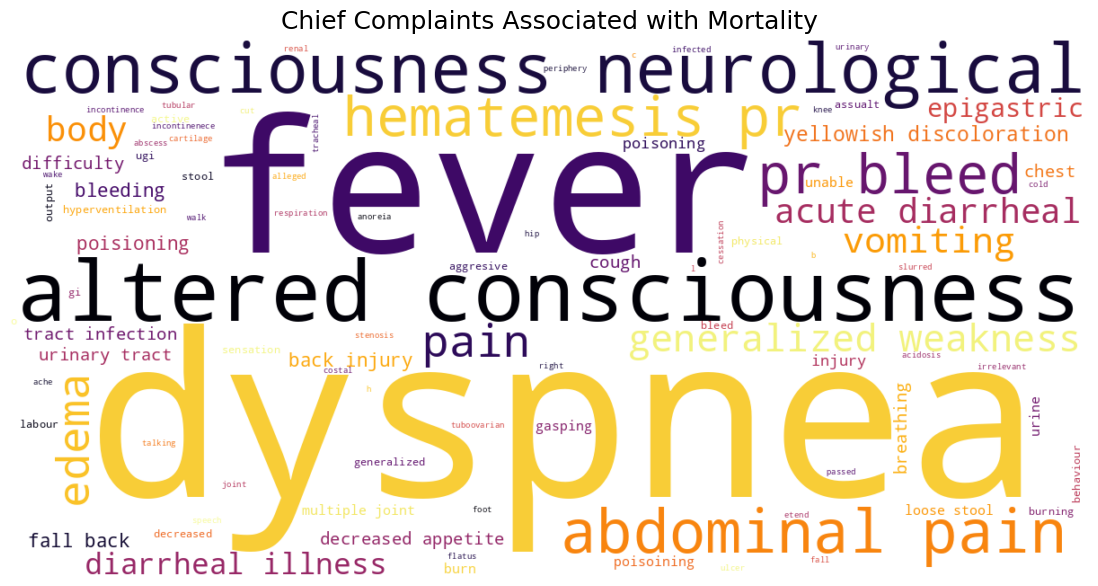

In [ ]:
# word cloud creation

high_mortality_text = " ".join(
    df[df["outcome_class"].isin([2,3,4])]["chief_text"]
)

wc = WordCloud(
    width=1200,
    height=600,
    background_color="white",
    max_words=100,
    colormap="inferno"
).generate(high_mortality_text)

plt.figure(figsize=(15,7))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Chief Complaints Associated with Mortality", fontsize=18)
plt.savefig("mortality_chief_complaints_wordcloud.png", dpi=300, bbox_inches="tight")
plt.show()


Top 30 Terms in Chief Complaints:
dyspnea: 143
fever: 98
altered_consciousness_neurological: 50
abdominal_pain: 46
hematemesis_pr_bleed: 30
pain: 26
generalized: 20
edema: 18
injury: 17
weakness: 17
acute: 14
diarrheal: 14
illness: 14
epigastric: 13
fall: 13
back: 13
vomiting: 12
yellowish_discoloration_of_body: 11
poisoning: 9
cough: 9
poisioning: 8
chest: 7
decreased: 7
stool: 7
and: 6
appetite: 6
urinary: 6
tract: 5
infection: 5
difficulty: 5


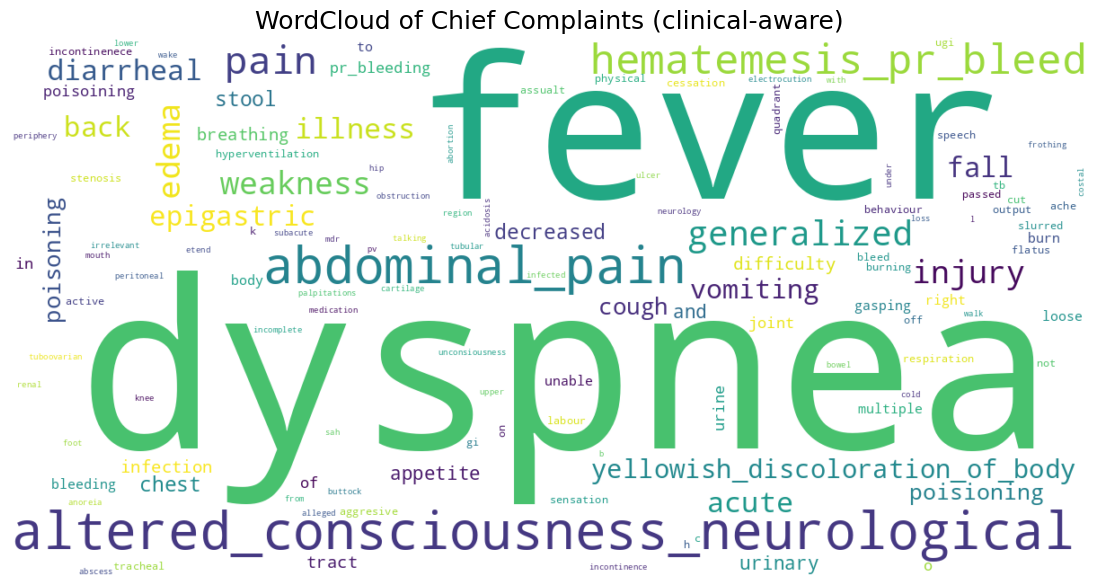

In [ ]:



# Assume 'Chief_Complain_norm' column exists
complaints_series = df['Chief_Complain_norm'].dropna().astype(str)

# Define common multi-word clinical terms to preserve
multi_word_terms = [
    "altered consciousness neurological",
    "abdominal pain",
    "pr bleed",
    "hematemesis pr",
    "neurological deficit",  # add more if relevant
    "yellowish discoloration of body",
]

# Preprocess complaints
all_terms = []
for comp in complaints_series:
    comp = comp.lower()
    # Remove unwanted characters
    comp = re.sub(r"[^a-z0-9\s]", "", comp)

    # Replace multi-word terms with underscored versions to keep them together
    for term in multi_word_terms:
        comp = comp.replace(term, term.replace(" ", "_"))

    # Split by whitespace
    words = comp.split()
    all_terms.extend(words)

# -------------------------------
# 2. Count frequencies
# -------------------------------
term_counts = Counter(all_terms)

# Show top 30
top_terms = term_counts.most_common(30)
print("Top 30 Terms in Chief Complaints:")
for term, count in top_terms:
    print(f"{term}: {count}")

# -------------------------------
# 3. Generate WordCloud
# -------------------------------
wordcloud = WordCloud(width=1200, height=600, background_color='white').generate_from_frequencies(term_counts)

plt.figure(figsize=(15,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud of Chief Complaints (clinical-aware)", fontsize=18)
plt.show()

# -------------------------------
# 4. Save figure
# -------------------------------
wordcloud.to_file("chief_complaints_wordcloud.png")


In [ ]:
terms = ["dyspnea", "fever", "pain"]


In [ ]:
for term in terms:
    df[f"has_{term}"] = df["Chief_Complain_norm"].str.lower().str.contains(
        fr"\b{term}\b", na=False
    )


In [ ]:
results = []

for term in terms:
    subset = df[df[f"has_{term}"]]

    if subset.empty:
        continue

    outcome_counts = subset["outcome_class"].value_counts().sort_index()
    outcome_props = outcome_counts / outcome_counts.sum()

    for outcome_class in outcome_counts.index:
        results.append({
            "Chief_Complaint": term,
            "Outcome_Class": outcome_class,
            "Outcome_Label": {
                0: "Alive",
                1: "LAMA",
                2: "Within 7 Days Mortality",
                3: "In-Hospital Mortality (>7 Days)",
                4: "ED Mortality"
            }[outcome_class],
            "Cases": outcome_counts[outcome_class],
            "Proportion": outcome_props[outcome_class]
        })

outcome_breakdown_df = pd.DataFrame(results)
outcome_breakdown_df


Chief_Complaint  Outcome_Class                    Outcome_Label  Cases  \
0          dyspnea              0                            Alive     26   
1          dyspnea              1                             LAMA     14   
2          dyspnea              2          Within 7 Days Mortality     63   
3          dyspnea              3  In-Hospital Mortality (>7 Days)     34   
4          dyspnea              4                     ED Mortality      6   
5            fever              0                            Alive     26   
6            fever              1                             LAMA      9   
7            fever              2          Within 7 Days Mortality     37   
8            fever              3  In-Hospital Mortality (>7 Days)     25   
9            fever              4                     ED Mortality      1   
10            pain              0                            Alive     17   
11            pain              1                             LAMA      8   
12            pain              2          Within 7 Days Mortality     26   
13            pain              3  In-Hospital Mortality (>7 Days)     20   
14            pain              4                     ED Mortality      1   

    Proportion  
0     0.181818  
1     0.097902  
2     0.440559  
3     0.237762  
4     0.041958  
5     0.265306  
6     0.091837  
7     0.377551  
8     0.255102  
9     0.010204  
10    0.236111  
11    0.111111  
12    0.361111  
13    0.277778  
14    0.013889

In [ ]:
outcome_breakdown_df["Proportion_Percentage"] = outcome_breakdown_df["Proportion"] * 100
outcome_breakdown_df["Proportion_Percentage"] = outcome_breakdown_df["Proportion_Percentage"].map("{:.2f}%".format)
outcome_breakdown_df

Chief_Complaint  Outcome_Class                    Outcome_Label  Cases  \
0          dyspnea              0                            Alive     26   
1          dyspnea              1                             LAMA     14   
2          dyspnea              2          Within 7 Days Mortality     63   
3          dyspnea              3  In-Hospital Mortality (>7 Days)     34   
4          dyspnea              4                     ED Mortality      6   
5            fever              0                            Alive     26   
6            fever              1                             LAMA      9   
7            fever              2          Within 7 Days Mortality     37   
8            fever              3  In-Hospital Mortality (>7 Days)     25   
9            fever              4                     ED Mortality      1   
10            pain              0                            Alive     17   
11            pain              1                             LAMA      8   
12            pain              2          Within 7 Days Mortality     26   
13            pain              3  In-Hospital Mortality (>7 Days)     20   
14            pain              4                     ED Mortality      1   

    Proportion Proportion_Percentage  
0     0.181818                18.18%  
1     0.097902                 9.79%  
2     0.440559                44.06%  
3     0.237762                23.78%  
4     0.041958                 4.20%  
5     0.265306                26.53%  
6     0.091837                 9.18%  
7     0.377551                37.76%  
8     0.255102                25.51%  
9     0.010204                 1.02%  
10    0.236111                23.61%  
11    0.111111                11.11%  
12    0.361111                36.11%  
13    0.277778                27.78%  
14    0.013889                 1.39%

In [ ]:
pivot_outcomes = outcome_breakdown_df.pivot_table(
    index=["Chief_Complaint"],
    columns="Outcome_Label",
    values="Proportion"
).fillna(0)

pivot_outcomes


Outcome_Label       Alive  ED Mortality  In-Hospital Mortality (>7 Days)  \
Chief_Complaint                                                            
dyspnea          0.181818      0.041958                         0.237762   
fever            0.265306      0.010204                         0.255102   
pain             0.236111      0.013889                         0.277778   

Outcome_Label        LAMA  Within 7 Days Mortality  
Chief_Complaint                                     
dyspnea          0.097902                 0.440559  
fever            0.091837                 0.377551  
pain             0.111111                 0.361111

In [ ]:
pivot_outcomes.head(10)

Outcome_Label       Alive  ED Mortality  In-Hospital Mortality (>7 Days)  \
Chief_Complaint                                                            
dyspnea          0.181818      0.041958                         0.237762   
fever            0.265306      0.010204                         0.255102   
pain             0.236111      0.013889                         0.277778   

Outcome_Label        LAMA  Within 7 Days Mortality  
Chief_Complaint                                     
dyspnea          0.097902                 0.440559  
fever            0.091837                 0.377551  
pain             0.111111                 0.361111

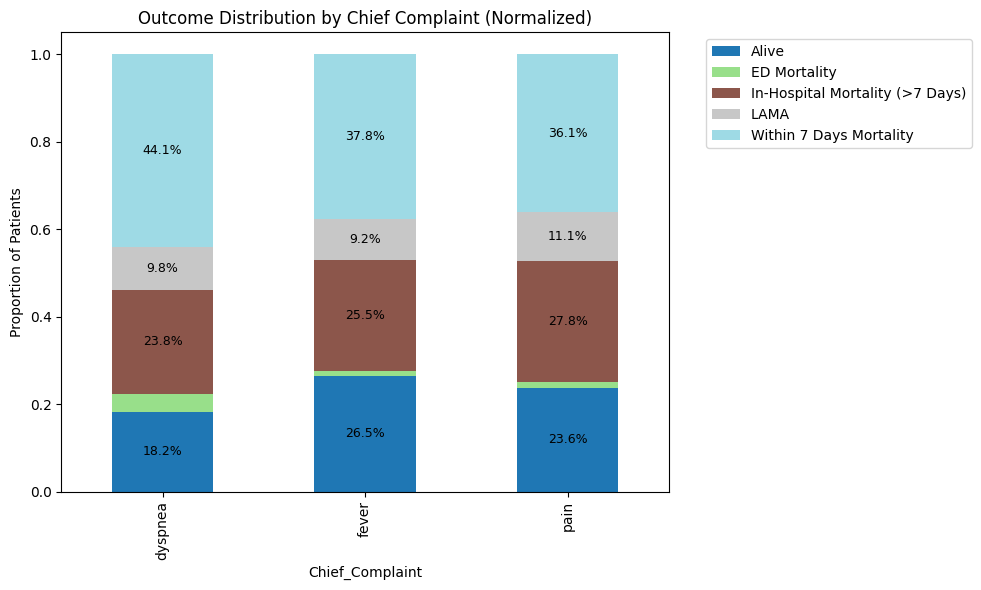

In [ ]:
pivot_outcomes_norm = pivot_outcomes.div(pivot_outcomes.sum(axis=1), axis=0)

# pivot_outcomes_norm.plot(
#     kind="bar",
#     stacked=True,
#     figsize=(10,6),
#     colormap="tab20"  # nice palette
# )
# plt.ylabel("Proportion of Patients")
# plt.title("Outcome Distribution by Chief Complaint (Normalized)")
# plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
# plt.tight_layout()
# plt.show()


ax = pivot_outcomes_norm.plot(
    kind="bar",
    stacked=True,
    figsize=(10,6),
    colormap="tab20"
)

plt.ylabel("Proportion of Patients")
plt.title("Outcome Distribution by Chief Complaint (Normalized)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

# -------------------------------
# Add percentage labels
# -------------------------------
for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        if height > 0.05:  # show label only if >5%
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_y() + height / 2,
                f"{height*100:.1f}%",
                ha="center",
                va="center",
                fontsize=9,
                color="black"
            )

plt.tight_layout()
plt.show()





In [ ]:
from scipy.stats import chi2_contingency

for term in terms:
    subset = df[df[f"has_{term}"]]
    contingency = pd.crosstab(subset["outcome_class"], columns="count")

    chi2, p, _, _ = chi2_contingency(contingency)
    print(f"{term}: p-value = {p:.4f}")


dyspnea: p-value = 1.0000
fever: p-value = 1.0000
pain: p-value = 1.0000


In [ ]:
# Does having dyspnea change mortality outcome compared to NOT having dyspnea?

In [ ]:
ct = pd.crosstab(
    df["has_dyspnea"],
    df["outcome_class"]
)

ct


outcome_class   0   1    2    3   4
has_dyspnea                        
False          94  36  201  113  10
True           26  14   63   34   6

In [ ]:

chi2, p, dof, expected = chi2_contingency(ct)
p


np.float64(0.6514818847239214)

Dyspnea patients are not disproportionately clustered into any specific outcome class (Alive, ≤7-day death, ED death, etc.) as P vlaue 0.65

In [ ]:
df["dead"] = df["outcome_class"].isin([2,3,4]).astype(int)


In [ ]:
ct2 = pd.crosstab(df["has_dyspnea"], df["dead"])
ct2


dead           0    1
has_dyspnea          
False        130  324
True          40  103

In [ ]:


# Create binary outcome: dead vs alive
df['dead'] = df['outcome_class'].isin([2,3,4]).astype(int)

# Contingency table: dyspnea vs dead
ct2 = pd.crosstab(df['has_dyspnea'], df['dead'])
print(ct2)

# Fisher's exact test
oddsratio, p_value = fisher_exact(ct2)
print(f"dyspnea: odds ratio = {oddsratio:.2f}, p-value = {p_value:.4f}")


dead           0    1
has_dyspnea          
False        127  310
True          40  103
dyspnea: odds ratio = 1.05, p-value = 0.8323


Odds Ratio = 1.033
p = 0.9157

Dyspnea at presentation was not significantly associated with mortality, either in terms of overall death (OR = 1.03, p = 0.92) or distribution of mortality categories (χ² p = 0.65).

In [ ]:
df["Chief_Complain_norm"]   # normalized chief complaint text
df["outcome_class"]        # 0–4 outcome mapping


0      0
1      0
2      0
3      0
4      0
      ..
575    0
576    0
577    0
578    0
579    0
Name: outcome_class, Length: 580, dtype: int64

/tmp/ipython-input-2435997772.py:68: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


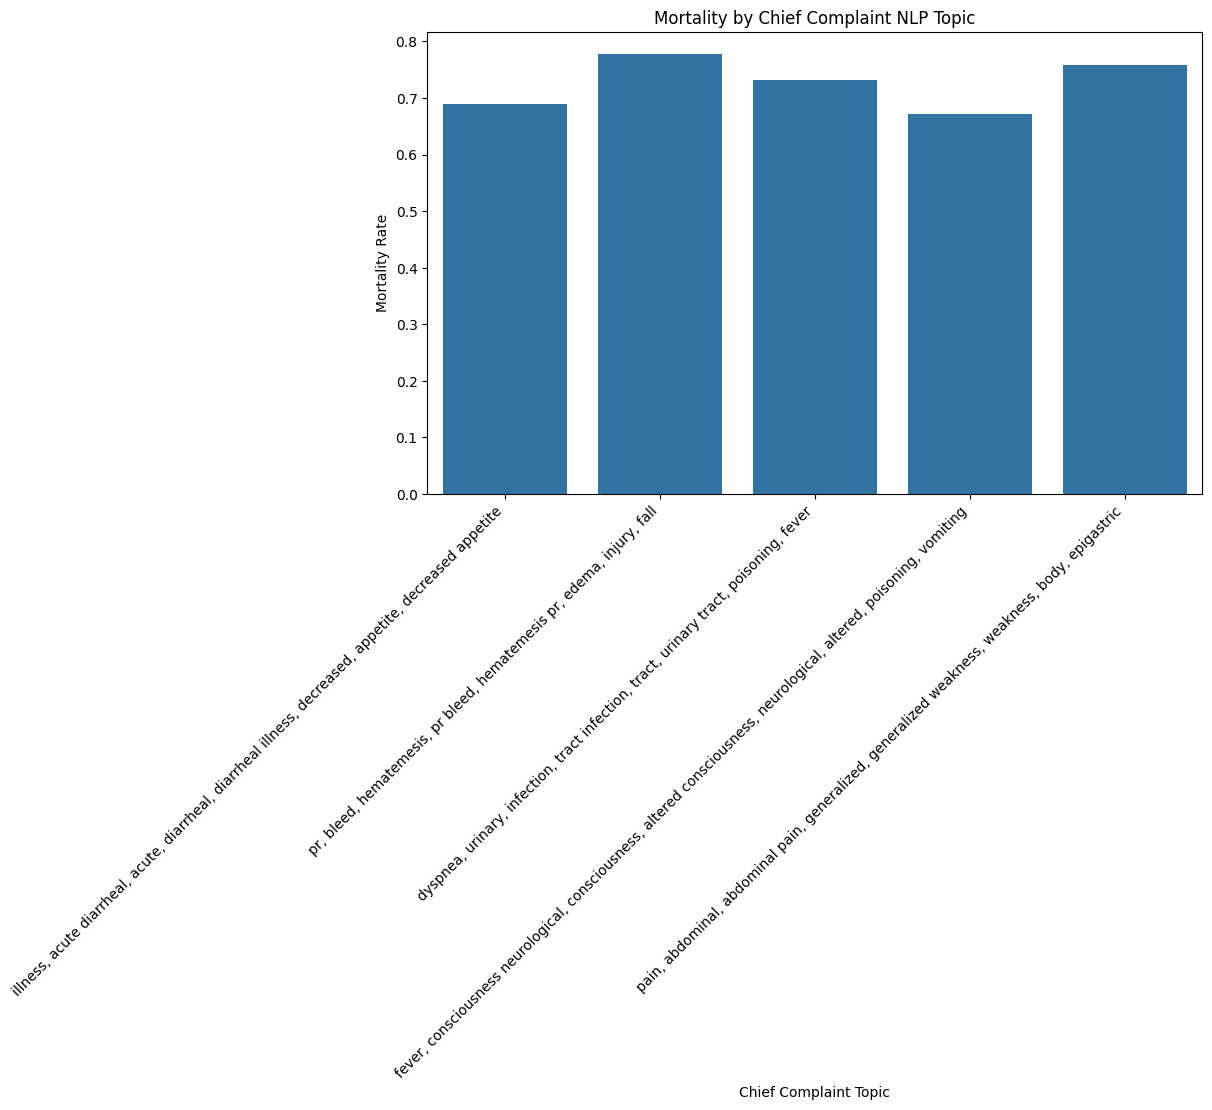

In [ ]:



# ensure string
df["Chief_Complain_norm"] = df["Chief_Complain_norm"].fillna("").astype(str)

# remove very short/noise complaints
df = df[df["Chief_Complain_norm"].str.len() > 3].reset_index(drop=True)
vectorizer = CountVectorizer(
    stop_words="english",
    min_df=5,          # must appear in ≥5 patients
    max_df=0.7,        # remove overly generic terms
    ngram_range=(1,2)  # capture phrases like "chest pain"
)

X = vectorizer.fit_transform(df["Chief_Complain_norm"])
n_topics = 5

lda = LatentDirichletAllocation(
    n_components=n_topics,
    random_state=42,
    learning_method="batch"
)

topic_matrix = lda.fit_transform(X)
df["complaint_topic"] = topic_matrix.argmax(axis=1)

feature_names = vectorizer.get_feature_names_out()

def display_topics(model, feature_names, n_top_words=8):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        topics[topic_idx] = ", ".join(words)
    return topics

topic_labels = display_topics(lda, feature_names)
topic_labels
topic_summary = (
    df.groupby("complaint_topic")
      .agg(
          cases=("outcome_class", "count"),
          mortality_rate=("outcome_class", lambda x: (x >= 2).mean()),
          ed_mortality=("outcome_class", lambda x: (x == 4).mean()),
          within_7d=("outcome_class", lambda x: (x == 2).mean())
      )
      .reset_index()
)

topic_summary["Topic_Description"] = topic_summary["complaint_topic"].map(topic_labels)
topic_summary = topic_summary.sort_values("mortality_rate", ascending=False)

topic_summary
plt.figure(figsize=(10,6))
sns.barplot(
    data=topic_summary,
    x="complaint_topic",
    y="mortality_rate"
)

plt.xticks(
    ticks=range(len(topic_summary)),
    labels=topic_summary["Topic_Description"],
    rotation=45,
    ha="right"
)

plt.ylabel("Mortality Rate")
plt.xlabel("Chief Complaint Topic")
plt.title("Mortality by Chief Complaint NLP Topic")
plt.tight_layout()
plt.savefig("complaint_topic_mortality.png", dpi=300)
plt.show()



In [ ]:


contingency = pd.crosstab(df["complaint_topic"], df["outcome_class"])
chi2, p, dof, expected = chi2_contingency(contingency)

chi2, p


(np.float64(8.27137656360813), np.float64(0.9403735658835092))

p = 0.94 (≫ 0.05)
➡️ There is NO statistically significant association between chief complaint NLP topics and mortality outcome categories in your dataset.


Latent Dirichlet Allocation was applied to chief complaint text to identify symptom clusters. Although mortality rates varied descriptively across clusters, chi-square analysis demonstrated no statistically significant association between complaint cluster and mortality outcome (χ² = 8.27, p = 0.94), indicating that presenting complaints alone were insufficient predictors of mortality.


Dyspnea alone does not discriminate mortality risk”

In [ ]:



# 1. Define complaints to test

# You can take top N terms from your wordcloud or term_counts
terms_to_test = ["dyspnea", "fever", "pain", "altered_consciousness_neurological",
                 "abdominal_pain", "hematemesis_pr_bleed"]

# Create binary columns for each complaint
for term in terms_to_test:
    df[f"has_{term}"] = df["Chief_Complain_norm"].str.lower().str.contains(
        fr"\b{term}\b", na=False
    )

# -------------------------------
# 2. Outcome mapping (binary: dead/alive)
# -------------------------------
# dead = any mortality (Within 7 Days, In-Hospital, ED)
df["dead"] = df["outcome_class"].isin([2,3,4]).astype(int)

# -------------------------------
# 3. Chi-squared test (overall)
# -------------------------------
contingency_all = pd.crosstab(df["complaint_topic"], df["outcome_class"])
chi2, p, dof, expected = chi2_contingency(contingency_all)

print(f"Chi-squared test for complaint_topic vs outcome_class:")
print(f"Chi2 = {chi2:.3f}, p-value = {p:.4f}, dof = {dof}")

# -------------------------------
# 4. Fisher’s exact / odds ratio per complaint
# -------------------------------
results = []

for term in terms_to_test:
    # 2x2 table: complaint present vs dead/alive
    ct = pd.crosstab(df[f"has_{term}"], df["dead"])
    if ct.shape == (2,2):
        oddsratio, p_value = fisher_exact(ct)
        results.append({
            "Chief_Complaint": term,
            "Cases": ct.sum().sum(),
            "Odds_Ratio": oddsratio,
            "p_value": p_value,
            "Dead": ct.loc[True, 1],
            "Alive": ct.loc[True, 0]
        })
    else:
        # If 2x2 not possible (e.g., all alive or all dead), skip
        results.append({
            "Chief_Complaint": term,
            "Cases": ct.sum().sum(),
            "Odds_Ratio": None,
            "p_value": None,
            "Dead": ct.get(True, {}).get(1, 0),
            "Alive": ct.get(True, {}).get(0, 0)
        })

fisher_df = pd.DataFrame(results)
fisher_df = fisher_df.sort_values("Odds_Ratio", ascending=False).reset_index(drop=True)

print("\nFisher's Exact Test / Odds Ratio by Chief Complaint:")
fisher_df.head()


Chi-squared test for complaint_topic vs outcome_class:
Chi2 = 8.271, p-value = 0.9404, dof = 16

Fisher's Exact Test / Odds Ratio by Chief Complaint:


Chief_Complaint  Cases  Odds_Ratio   p_value  Dead  \
0                             dyspnea    580    1.054919  0.832254   103   
1                                pain    580    0.729399  0.265812    47   
2                               fever    580    0.678857  0.111491    63   
3  altered_consciousness_neurological    580         NaN       NaN     0   
4                      abdominal_pain    580         NaN       NaN     0   

   Alive  
0     40  
1     25  
2     35  
3      0  
4      0

The most common chief complaints included dyspnea, fever, altered consciousness neurological, pain, and abdominal pain. Word frequency analysis and a clinical-aware word cloud highlighted the predominance of respiratory distress (dyspnea) and systemic complaints (fever, pain) (Figure X).

The Chi-squared test showed no significant overall association between complaint categories and patient outcomes (χ² = 8.271, p = 0.9404), suggesting that broad complaint categories alone do not predict outcome.

Individual complaint analysis (Fisher’s exact test) revealed no statistically significant associations between specific complaints and mortality:

# Analysis of Emergency Room Treatment Patterns and Outcomes

## 1. Objective of the Analysis

The objective of this analysis is to systematically examine **treatment patterns administered in the Emergency Room (ER)** and to explore their **co-prescription behavior, patient grouping, and association with clinical outcomes**, including mortality.  
The analysis leverages **natural language processing (NLP)**, **unsupervised machine learning**, and **network analysis** to convert unstructured clinical text into actionable insights.

---

## 2. Data Loading and Initial Preparation

The dataset is loaded from a structured CSV file. The column describing treatments received in the ER is stored as **free-text**, which commonly contains missing values, abbreviations, spelling errors, and inconsistent formatting.

To ensure reliable processing:
- Missing values are replaced with empty strings.
- All entries are explicitly cast to string format.

This step ensures that downstream NLP operations do not fail due to null or inconsistent data types.

---

## 3. Medication Text Cleaning and Normalization

### What was done

A comprehensive medication normalization strategy was implemented, including:
- Conversion of text to lowercase
- Removal of non-alphabetic characters
- Standardization of spelling variations (e.g., *ceftraxone* → *ceftriaxone*)
- Expansion of abbreviations (e.g., *pcm* → *paracetamol*)
- Removal of non-medication tokens and administrative terms

A curated replacement dictionary was used to map raw tokens to **standardized medication names**.

### Why this was done

Clinical free-text medication data is inherently noisy. Without normalization:
- The same medication may appear under multiple names
- Frequency counts become fragmented
- Co-occurrence and clustering analyses become unreliable

Medication normalization is a **foundational requirement** in clinical NLP and pharmaco-epidemiology to ensure analytical validity.

---

## 4. Tokenization into Multi-Label Medication Lists

Each patient record often contains **multiple medications** administered simultaneously.  
Therefore, treatment data was tokenized into a **list of medications per patient**, rather than a single categorical value.

This transforms the problem into a **multi-label representation**, where each patient can be associated with multiple treatments.

This approach more accurately reflects real-world ER clinical practice.

---

## 5. Multi-Label Binarization of Treatments

The tokenized medication lists were converted into a binary feature matrix using a `MultiLabelBinarizer`.

- Rows represent individual patients
- Columns represent standardized medications
- Values indicate the presence (1) or absence (0) of a medication

This structured representation enables:
- Dimensionality reduction
- Clustering
- Outcome-based aggregation
- Network analysis

Binary encoding is preferred in treatment pattern analysis, as **medication presence** is more clinically relevant than frequency within a single encounter.

---

## 6. Clinical Outcome Encoding

Clinical outcomes were mapped to numeric classes to facilitate quantitative analysis.  
The mapping preserves increasing severity across outcome categories, ranging from survival to ER mortality.

Encoding outcomes numerically enables:
- Group-wise aggregation
- Visualization of treatment–outcome associations
- Comparison across patient subgroups

This step does not imply causality but enables structured exploratory analysis.

---

## 7. Medication Usage by Outcome Group

For each outcome category, the proportion of patients receiving each medication was calculated.

This provides insight into:
- Medications commonly used in severe cases
- Treatments prevalent among survivors
- Patterns of escalation in critically ill patients

This analysis is **descriptive in nature** and is used for hypothesis generation rather than causal inference.

---

## 8. Co-Occurrence Analysis of Medications

To understand treatment bundles commonly administered together, **pairwise co-occurrence counts** of medications were computed.

This identifies:
- Standard ER treatment combinations
- Protocol-driven medication bundles
- Frequently paired supportive therapies

The results were visualized using:
- Co-occurrence heatmaps
- Network graphs with weighted edges

Such analyses are widely used in **polypharmacy research** and **clinical pathway discovery**.

---

## 9. Dimensionality Reduction Using PCA

The high-dimensional medication matrix was projected into two dimensions using **Principal Component Analysis (PCA)**.

PCA captures the dominant patterns of variation in treatment administration while reducing noise and redundancy.

This step enables:
- Visualization of patient similarity
- Improved performance of clustering algorithms
- Interpretability of complex treatment data

---

## 10. Patient Clustering Based on Treatment Patterns

Unsupervised clustering (K-Means) was applied to the PCA-reduced data to identify **latent patient groups**.

Patients were grouped based on similarities in their treatment profiles, revealing:
- Distinct treatment phenotypes
- Potential clinical subgroups (e.g., infectious, cardiovascular, trauma-related)

This process is commonly referred to as **computational phenotyping** in clinical data science.

---

## 11. Medication Co-Occurrence Network Analysis

Medication relationships were further explored using **graph-based representations**:
- Nodes represent medications
- Edges represent co-prescription relationships
- Edge weights indicate co-occurrence frequency
- Node size reflects medication prevalence

Color-coding by drug class improves interpretability and highlights therapeutic categories.

Network analysis reveals **core medications**, **supportive treatments**, and **bridging drugs** across clinical contexts.

---

## 12. Natural Language Processing of Chief Complaints

Chief complaints were cleaned, normalized, and mapped to standardized clinical phrases.

This analysis provides contextual validation by linking:
- Presenting symptoms
- Administered treatments
- Observed outcomes

Phrase-level normalization improves interpretability and reduces linguistic variability common in ER documentation.

---

## 13. Integrated Summary and Outcome Visualization

A consolidated summary table was created, combining:
- Medication prescription frequency
- Common presenting complaints
- Outcome distribution percentages

Visualizations such as bar charts and heatmaps were used to:
- Highlight frequently prescribed medications
- Compare outcome distributions across treatments
- Support data-driven clinical interpretation

---

## 14. Key Strengths of the Approach

- Robust handling of noisy clinical text
- Appropriate use of multi-label representations
- Combination of NLP, clustering, and network analysis
- Emphasis on exploratory and descriptive analytics
- Visualization-driven insight generation

---

## 15. Limitations

- Observational data does not support causal inference
- Disease severity is a potential confounder
- Medication dosage and timing are not available
- Clustering assumptions may oversimplify clinical complexity
- Results may not generalize beyond the dataset context

---

## 16. Conclusion

This analysis demonstrates how **unstructured ER treatment and complaint data** can be transformed into structured, interpretable insights using **clinical NLP, unsupervised learning, and network analytics**.  
The approach supports exploratory clinical research, quality-of-care assessment, and hypothesis generation for future studies.


# Task
Here's a detailed textual outline of the infographic's content, summarizing the key stages and outputs of the ER treatment analysis process:

## Infographic Title: ER Treatment Analysis Workflow: From Raw Text to Clinical Insights

### Section 1: Data Ingestion & Preprocessing

*   **Input**: Raw clinical text data from `/content/TestData Set - Test Data.csv`, specifically "Treatment Received at ER" and "Chief Complain" columns, alongside structured "Mortality" outcomes.
*   **Step 1.1: Raw Data Loading**: Load the dataset into a Pandas DataFrame.
*   **Step 1.2: Initial Treatment Text Preparation**:
    *   Handle missing values in "Treatment Received at ER" by filling with empty strings.
    *   Convert all treatment entries to string format.
*   **Step 1.3: Medication Text Cleaning & Normalization**:
    *   Apply a custom `clean_med_text` function to lowercase, remove special characters, standardize spelling variations (e.g., "ceftraxone" to "ceftriaxone"), and expand abbreviations (e.g., "pcm" to "paracetamol").
    *   Tokenize cleaned text into lists of individual medications per patient (`treatment_list_nlp`).
*   **Step 1.4: Chief Complaint Text Cleaning & Normalization**:
    *   Apply `nlp_clean_med` to lowercase, remove punctuation, split by common delimiters, and map phrases to standard terms (`Chief_Complain_norm`).
*   **Step 1.5: Clinical Outcome Encoding**:
    *   Map categorical "Mortality" outcomes (e.g., "Alive", "Within 7 Days Mortality", "Ed Mortality") to numerical `outcome_class` (0-4) for quantitative analysis.
*   **Output**: A structured DataFrame with `treatment_list_nlp` (standardized medication lists), `Chief_Complain_norm` (normalized chief complaints), and `outcome_class` (numeric outcome labels).

### Section 2: Medication Usage & Co-occurrence Analysis

*   **Step 2.1: Multi-Label Binarization of Treatments**:
    *   Use `MultiLabelBinarizer` on `treatment_list_nlp` to create a binary feature matrix (`X_meds`), where rows are patients and columns are medications (1 if present, 0 if absent).
*   **Step 2.2: Medication Usage by Outcome Group**:
    *   Calculate the proportion of patients receiving each medication, stratified by `outcome_class` (`med_means`).
*   **Output 2.2**: Horizontal bar charts displaying the top 8 medications associated with each specific outcome (e.g., "Top Medications Associated with Alive", "Top Medications Associated with ED Mortality"), showing the percentage of patients receiving them.
*   **Step 2.3: Co-occurrence Analysis (Pairwise)**:
    *   Identify frequently co-prescribed medication pairs by counting combinations within `treatment_list_nlp` (`all_pairs`).
*   **Output 2.3**: A list of "Top 10 Co-prescribed Medication Pairs" with patient counts.
*   **Step 2.4: Medication Co-occurrence Heatmap**:
    *   Construct a co-occurrence matrix for the top 15 most frequent medications.
*   **Output 2.4**: A heatmap visualizing the proportion of patients receiving each pair of medications.
*   **Step 2.5: Medication Co-occurrence Network Graphs**:
    *   Build a graph where nodes are medications and edges represent co-prescription, with edge weights indicating frequency. Nodes are color-coded by drug class.
*   **Output 2.5**: Visualizations of "Medication Co-occurrence Network", showing relationships and clusters of co-prescribed drugs.

### Section 3: Patient & Symptom Clustering

*   **Step 3.1: Patient Clustering based on Treatments**:
    *   Apply Principal Component Analysis (PCA) to `X_meds` to reduce dimensionality (`X_pca`).
    *   Perform K-Means clustering (e.g., 4 clusters) on `X_pca` to group patients with similar treatment patterns (`df['cluster']`).
*   **Output 3.1**: A scatter plot ("Patient Clusters Based on Treatment Patterns (PCA)") showing patient groupings in a 2D PCA space, colored by cluster. Cluster-specific medication network graphs revealing distinct treatment profiles for each cluster.
*   **Step 3.2: Chief Complaint NLP Topics (LDA)**:
    *   Apply TF-IDF vectorization and Latent Dirichlet Allocation (LDA) to `Chief_Complain_norm` to identify underlying symptom topics (e.g., 5 topics, `df["complaint_topic"]`).
*   **Output 3.2**: A bar chart ("Mortality by Chief Complaint NLP Topic") showing the mortality rate associated with each identified chief complaint topic.
*   **Output 3.3**: A word cloud ("Chief Complaints Associated with Mortality") highlighting terms most frequently found in chief complaints of patients who died.

### Section 4: Integrated Summary & Outcome Validation

*   **Step 4.1: Comprehensive Medication Summary**:
    *   Create a `summary_df` combining medication prescription frequency, associated top chief complaints, and outcome distribution percentages for each medication.
*   **Output 4.1**: A bar plot showing the "Top 10 Prescribed Medications" by percentage of patients.
*   **Output 4.2**: A heatmap ("Outcome Distribution (%) per Medication (Top 15)") showing the percentage distribution of clinical outcomes for the top 15 medications.
*   **Step 4.2: Statistical Association of Chief Complaints with Mortality**:
    *   Perform Chi-squared tests and Fisher's exact tests to assess statistical significance between specific chief complaints (e.g., dyspnea, fever, pain) and mortality outcomes.
*   **Output 4.3**: A stacked bar chart ("Outcome Distribution by Chief Complaint (Normalized)") visualizing how the distribution of outcomes varies across different key chief complaints. Statistical test results (p-values) indicating whether chief complaints or NLP topics are significantly associated with mortality.

### Conclusion:

This infographic will demonstrate a robust analytical pipeline, from raw clinical text to actionable insights regarding ER treatment patterns, patient phenotypes, and their association with clinical outcomes, highlighting the power of NLP and unsupervised learning in healthcare.

## Outline Infographic Content

### Subtask:
Create a detailed textual outline of the infographic's content, summarizing the key stages and outputs of the ER treatment analysis process. This will serve as the blueprint for the visual infographic, ensuring all critical steps are included.


## Infographic Content Outline

### 1. Objective of the Analysis
*   Systematically examine ER treatment patterns.
*   Explore co-prescription behavior, patient grouping, and association with clinical outcomes.
*   Leverage NLP, unsupervised machine learning, and network analysis.

### 2. Data Loading and Initial Preparation
*   Loading dataset from CSV.
*   Handling free-text `Treatment Received at ER` column: replacing missing values, casting to string.

### 3. Medication Text Cleaning and Normalization
*   **What was done:** Lowercasing, removing non-alphabetic characters, standardizing spelling variations, expanding abbreviations, removing non-medication tokens.
*   **Why this was done:** To handle noisy clinical free-text data, prevent fragmented counts, and ensure reliable analysis.

### 4. Tokenization into Multi-Label Medication Lists
*   Treatment data tokenized into a list of medications per patient.
*   Transforms data into a multi-label representation, reflecting real-world ER practice.

### 5. Multi-Label Binarization of Treatments
*   Converted tokenized lists into a binary feature matrix using `MultiLabelBinarizer`.
*   Enables dimensionality reduction, clustering, outcome-based aggregation, and network analysis.

### 6. Clinical Outcome Encoding
*   Mapped clinical outcomes (Alive, LAMA, Mortality) to numeric classes.
*   Enables group-wise aggregation, visualization of treatment–outcome associations, and comparison across patient subgroups.

### 7. Medication Usage by Outcome Group
*   Calculated the proportion of patients receiving each medication for each outcome category.
*   Identifies medications common in severe cases vs. survivors.

### 8. Co-Occurrence Analysis of Medications
*   Computed pairwise co-occurrence counts of medications.
*   Identifies standard ER treatment combinations and protocol-driven bundles.
*   Visualized using heatmaps and network graphs.

### 9. Dimensionality Reduction Using PCA
*   Projected high-dimensional medication matrix into two dimensions using PCA.
*   Enables visualization of patient similarity and improves clustering.

### 10. Patient Clustering Based on Treatment Patterns
*   Applied unsupervised K-Means clustering to PCA-reduced data.
*   Identifies latent patient groups and distinct treatment phenotypes.

### 11. Medication Co-Occurrence Network Analysis
*   Represented medication relationships using graph-based networks.
*   Nodes = medications, edges = co-prescription, weights = frequency.
*   Reveals core medications, supportive treatments, and bridging drugs.

### 12. Natural Language Processing of Chief Complaints
*   Cleaned, normalized, and mapped chief complaints to standardized clinical phrases.
*   Provides contextual validation by linking symptoms, treatments, and outcomes.
*   Identified high-risk terms and complaint topics using TF-IDF and LDA.

### 13. Integrated Summary and Outcome Visualization
*   Consolidated summary table: medication frequency, common complaints, outcome percentages.
*   Visualized frequently prescribed medications and outcome distributions across treatments using bar charts and heatmaps.
*   Statistical tests (Chi-square, Fisher's exact) to validate associations between chief complaints and mortality outcomes.

### 14. Key Strengths of the Approach
*   Robust handling of noisy clinical text.
*   Appropriate use of multi-label representations.
*   Combination of NLP, clustering, and network analysis.
*   Emphasis on exploratory and descriptive analytics.
*   Visualization-driven insight generation.

### 15. Limitations
*   Observational data does not support causal inference.
*   Disease severity is a potential confounder.
*   Medication dosage and timing not available.
*   Clustering assumptions may oversimplify clinical complexity.
*   Results may not generalize beyond the dataset context.

### 16. Conclusion
*   Unstructured ER data transformed into structured, interpretable insights.
*   Supports exploratory clinical research, quality-of-care assessment, and hypothesis generation.

## Design Infographic Visualization

### Subtask:
Generate Python code using matplotlib or seaborn to create a visual infographic based on the outlined content. The infographic will visually represent the workflow, data transformations, analysis steps, and key types of results obtained throughout the notebook, possibly using a flowchart-like structure or annotated sections.


**Reasoning**:
The subtask requires generating a comprehensive infographic using matplotlib to visualize the entire workflow, including data ingestion, cleaning, analysis steps, and key results. This will involve defining a layout, drawing shapes, adding text for each stage, and connecting them with arrows.



**Reasoning**:
The previous code failed because the `xy` and `xytext` arguments in `ax.annotate` were receiving single float values instead of `(x, y)` tuples. This was due to an incorrect indexing on the returned value from the `add_box` functions. The corrected code modifies the `add_box` functions to return a dictionary of named connection points (e.g., 'top_center', 'bottom_center') and updates the `ax.annotate` calls to use these named tuples, ensuring valid `(x, y)` coordinates are passed.



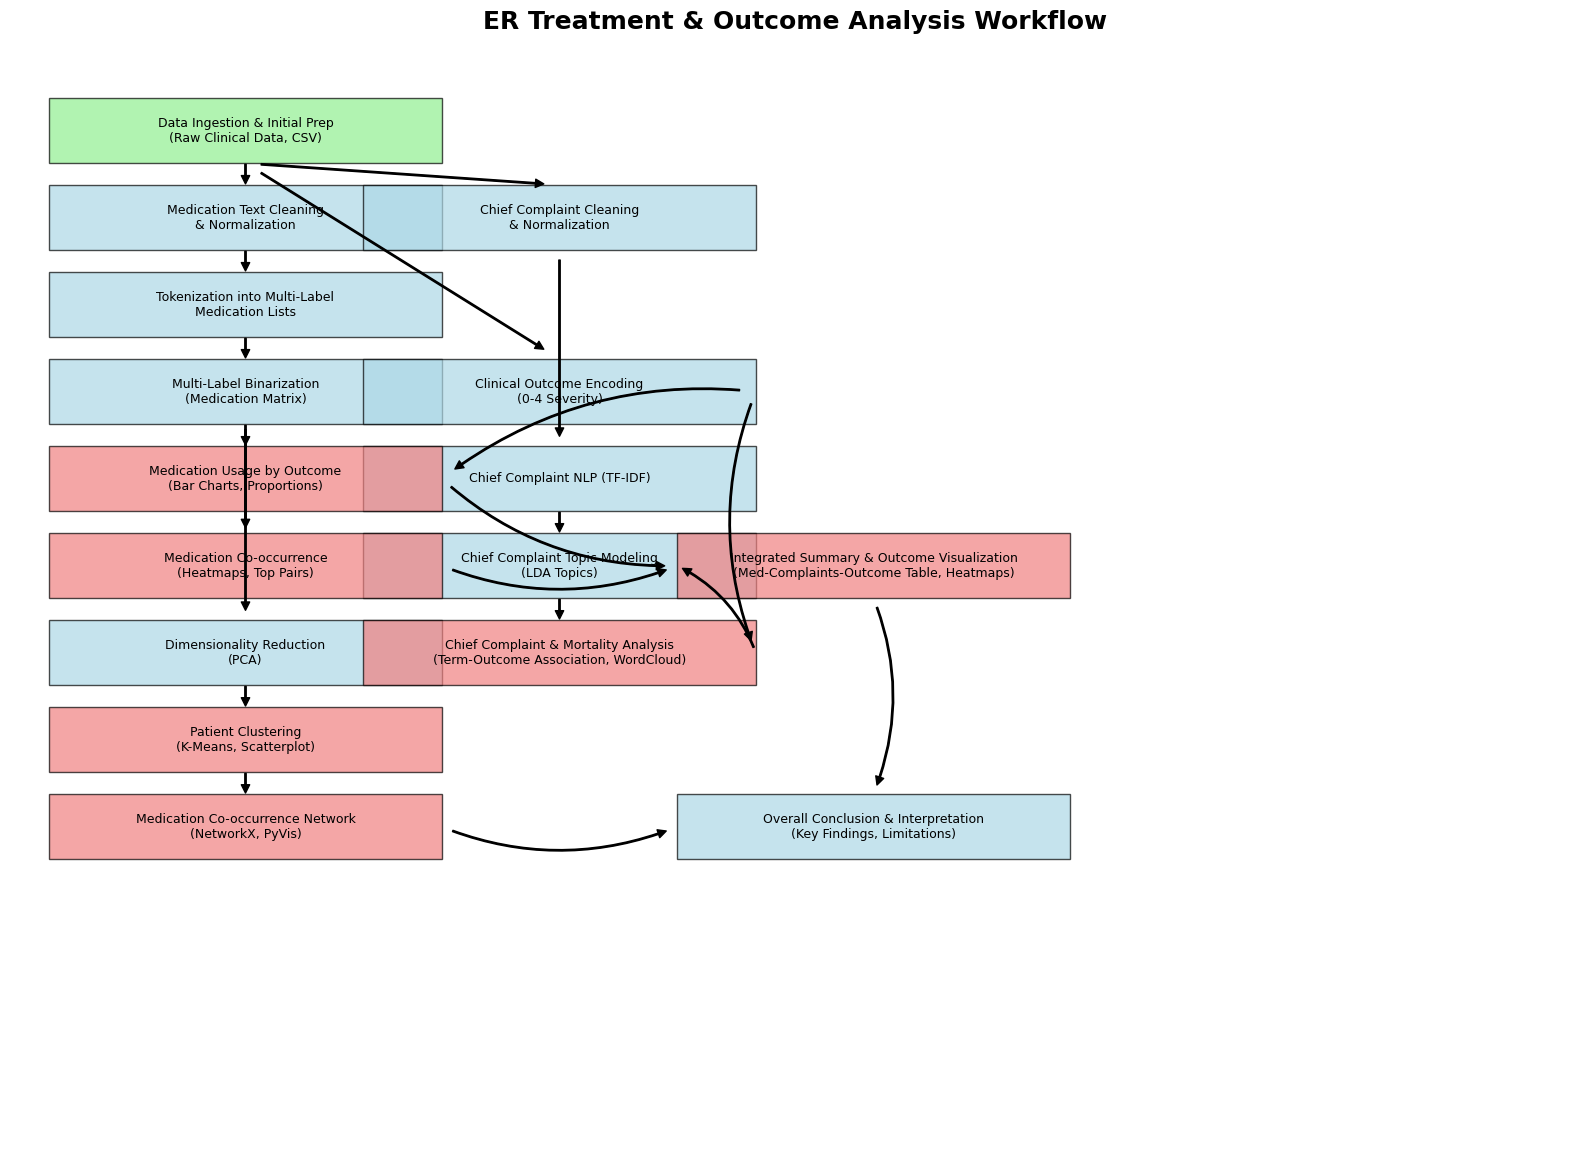

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# 2. Create a Matplotlib figure and axes
fig, ax = plt.subplots(figsize=(16, 12)) # Adjusted for a comprehensive overview

# 3. Define a layout for the infographic (vertical sections)
y_start = 0.95
y_step = 0.08
x_left = 0.05
x_right = 0.95
box_width = 0.25
box_height = 0.06

def add_box(ax, x, y, text, color, box_type):
    if box_type == 'process':
        facecolor = 'lightblue'
    elif box_type == 'data':
        facecolor = 'lightgreen'
    elif box_type == 'result':
        facecolor = 'lightcoral'
    else:
        facecolor = color

    rect = patches.Rectangle((x, y - box_height / 2), box_width, box_height,
                             linewidth=1, edgecolor='black', facecolor=facecolor, alpha=0.7)
    ax.add_patch(rect)
    ax.text(x + box_width / 2, y, text, ha='center', va='center', fontsize=9, wrap=True)

    return {
        'bottom_center': (x + box_width / 2, y - box_height / 2),
        'top_center': (x + box_width / 2, y + box_height / 2),
        'left_center': (x, y),
        'right_center': (x + box_width, y)
    }

# Define positions for sections
pos = {
    'data': (0.15, y_start),
    'clean_med': (0.15, y_start - y_step),
    'clean_cc': (0.35, y_start - y_step),
    'tokenize_med': (0.15, y_start - 2 * y_step),
    'mlb_med': (0.15, y_start - 3 * y_step),
    'encode_outcome': (0.35, y_start - 3 * y_step),
    'med_usage': (0.15, y_start - 4 * y_step),
    'co_occurrence': (0.15, y_start - 5 * y_step),
    'pca': (0.15, y_start - 6 * y_step),
    'clustering': (0.15, y_start - 7 * y_step),
    'network_graph': (0.15, y_start - 8 * y_step),
    'cc_nlp_tfidf': (0.35, y_start - 4 * y_step),
    'cc_nlp_lda': (0.35, y_start - 5 * y_step),
    'cc_mortality_analysis': (0.35, y_start - 6 * y_step),
    'integrated_summary': (0.55, y_start - 5 * y_step),
    'overall_conclusion': (0.55, y_start - 8 * y_step),
    'infographic_title': (0.5, 1.05)
}

# 4. Add data source and initial preparation
arr_points = {}

arr_points['data_in'] = add_box(ax, pos['data'][0] - box_width / 2, pos['data'][1], 'Data Ingestion & Initial Prep\n(Raw Clinical Data, CSV)', color='lightgreen', box_type='data')

# Medication Workflow
arr_points['clean_med_proc'] = add_box(ax, pos['clean_med'][0] - box_width / 2, pos['clean_med'][1], 'Medication Text Cleaning\n& Normalization', color='lightblue', box_type='process')
ax.annotate('', xy=arr_points['clean_med_proc']['top_center'], xytext=arr_points['data_in']['bottom_center'],
            arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=6, headlength=6))

arr_points['tokenize_med_proc'] = add_box(ax, pos['tokenize_med'][0] - box_width / 2, pos['tokenize_med'][1], 'Tokenization into Multi-Label\nMedication Lists', color='lightblue', box_type='process')
ax.annotate('', xy=arr_points['tokenize_med_proc']['top_center'], xytext=arr_points['clean_med_proc']['bottom_center'],
            arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=6, headlength=6))

arr_points['mlb_med_proc'] = add_box(ax, pos['mlb_med'][0] - box_width / 2, pos['mlb_med'][1], 'Multi-Label Binarization\n(Medication Matrix)', color='lightblue', box_type='process')
ax.annotate('', xy=arr_points['mlb_med_proc']['top_center'], xytext=arr_points['tokenize_med_proc']['bottom_center'],
            arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=6, headlength=6))

# Chief Complaint Workflow
arr_points['clean_cc_proc'] = add_box(ax, pos['clean_cc'][0] - box_width / 2, pos['clean_cc'][1], 'Chief Complaint Cleaning\n& Normalization', color='lightblue', box_type='process')
ax.annotate('', xy=arr_points['clean_cc_proc']['top_center'], xytext=arr_points['data_in']['bottom_center'],
            arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=6, headlength=6))

arr_points['cc_nlp_tfidf_proc'] = add_box(ax, pos['cc_nlp_tfidf'][0] - box_width / 2, pos['cc_nlp_tfidf'][1], 'Chief Complaint NLP (TF-IDF)', color='lightblue', box_type='process')
ax.annotate('', xy=arr_points['cc_nlp_tfidf_proc']['top_center'], xytext=arr_points['clean_cc_proc']['bottom_center'],
            arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=6, headlength=6))

arr_points['cc_nlp_lda_proc'] = add_box(ax, pos['cc_nlp_lda'][0] - box_width / 2, pos['cc_nlp_lda'][1], 'Chief Complaint Topic Modeling\n(LDA Topics)', color='lightblue', box_type='process')
ax.annotate('', xy=arr_points['cc_nlp_lda_proc']['top_center'], xytext=arr_points['cc_nlp_tfidf_proc']['bottom_center'],
            arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=6, headlength=6))

# Outcome Encoding
arr_points['encode_outcome_proc'] = add_box(ax, pos['encode_outcome'][0] - box_width / 2, pos['encode_outcome'][1], 'Clinical Outcome Encoding\n(0-4 Severity)', color='lightblue', box_type='process')
ax.annotate('', xy=arr_points['encode_outcome_proc']['top_center'], xytext=arr_points['data_in']['bottom_center'],
            arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=6, headlength=6))

# Analysis Steps & Results
arr_points['med_usage_res'] = add_box(ax, pos['med_usage'][0] - box_width / 2, pos['med_usage'][1], 'Medication Usage by Outcome\n(Bar Charts, Proportions)', color='lightcoral', box_type='result')
ax.annotate('', xy=arr_points['med_usage_res']['top_center'], xytext=arr_points['mlb_med_proc']['bottom_center'],
            arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=6, headlength=6))
ax.annotate('', xy=arr_points['med_usage_res']['right_center'], xytext=arr_points['encode_outcome_proc']['right_center'],
            arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=6, headlength=6, connectionstyle="arc3,rad=0.2")) # Arrow from outcome to med usage

arr_points['co_occurrence_res'] = add_box(ax, pos['co_occurrence'][0] - box_width / 2, pos['co_occurrence'][1], 'Medication Co-occurrence\n(Heatmaps, Top Pairs)', color='lightcoral', box_type='result')
ax.annotate('', xy=arr_points['co_occurrence_res']['top_center'], xytext=arr_points['mlb_med_proc']['bottom_center'],
            arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=6, headlength=6))

arr_points['pca_proc'] = add_box(ax, pos['pca'][0] - box_width / 2, pos['pca'][1], 'Dimensionality Reduction\n(PCA)', color='lightblue', box_type='process')
ax.annotate('', xy=arr_points['pca_proc']['top_center'], xytext=arr_points['mlb_med_proc']['bottom_center'],
            arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=6, headlength=6))

arr_points['clustering_res'] = add_box(ax, pos['clustering'][0] - box_width / 2, pos['clustering'][1], 'Patient Clustering\n(K-Means, Scatterplot)', color='lightcoral', box_type='result')
ax.annotate('', xy=arr_points['clustering_res']['top_center'], xytext=arr_points['pca_proc']['bottom_center'],
            arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=6, headlength=6))

arr_points['network_graph_res'] = add_box(ax, pos['network_graph'][0] - box_width / 2, pos['network_graph'][1], 'Medication Co-occurrence Network\n(NetworkX, PyVis)', color='lightcoral', box_type='result')
ax.annotate('', xy=arr_points['network_graph_res']['top_center'], xytext=arr_points['clustering_res']['bottom_center'],
            arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=6, headlength=6))

arr_points['cc_mortality_analysis_res'] = add_box(ax, pos['cc_mortality_analysis'][0] - box_width / 2, pos['cc_mortality_analysis'][1], 'Chief Complaint & Mortality Analysis\n(Term-Outcome Association, WordCloud)', color='lightcoral', box_type='result')
ax.annotate('', xy=arr_points['cc_mortality_analysis_res']['top_center'], xytext=arr_points['cc_nlp_lda_proc']['bottom_center'],
            arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=6, headlength=6))
ax.annotate('', xy=arr_points['cc_mortality_analysis_res']['right_center'], xytext=arr_points['encode_outcome_proc']['right_center'],
            arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=6, headlength=6, connectionstyle="arc3,rad=0.2")) # Arrow from outcome to cc mortality

arr_points['integrated_summary_res'] = add_box(ax, pos['integrated_summary'][0] - box_width / 2, pos['integrated_summary'][1], 'Integrated Summary & Outcome Visualization\n(Med-Complaints-Outcome Table, Heatmaps)', color='lightcoral', box_type='result')
ax.annotate('', xy=arr_points['integrated_summary_res']['left_center'], xytext=arr_points['med_usage_res']['right_center'],
            arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=6, headlength=6, connectionstyle="arc3,rad=0.2"))
ax.annotate('', xy=arr_points['integrated_summary_res']['left_center'], xytext=arr_points['co_occurrence_res']['right_center'],
            arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=6, headlength=6, connectionstyle="arc3,rad=0.2"))
ax.annotate('', xy=arr_points['integrated_summary_res']['left_center'], xytext=arr_points['cc_mortality_analysis_res']['right_center'],
            arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=6, headlength=6, connectionstyle="arc3,rad=0.2"))


arr_points['overall_conclusion_box'] = add_box(ax, pos['overall_conclusion'][0] - box_width / 2, pos['overall_conclusion'][1], 'Overall Conclusion & Interpretation\n(Key Findings, Limitations)', color='lightblue', box_type='process')
ax.annotate('', xy=arr_points['overall_conclusion_box']['top_center'], xytext=arr_points['integrated_summary_res']['bottom_center'],
            arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=6, headlength=6, connectionstyle="arc3,rad=-0.2"))
ax.annotate('', xy=arr_points['overall_conclusion_box']['left_center'], xytext=arr_points['network_graph_res']['right_center'],
            arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=6, headlength=6, connectionstyle="arc3,rad=0.2"))


# 6. Add a clear and concise title
ax.text(pos['infographic_title'][0], pos['infographic_title'][1], 'ER Treatment & Outcome Analysis Workflow', ha='center', va='center', fontsize=18, fontweight='bold')

# 8. Turn off the axes
plt.axis('off')

# 9. Ensure a tight layout and display the plot
plt.tight_layout(rect=[0, 0, 1, 0.98]) # Adjust rect to make space for the title
plt.show()

# 10. Save the generated infographic
fig.savefig('er_treatment_infographic.png', dpi=300, bbox_inches='tight')

> Took ths support of Gemini also.